In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset

import medmnist
from medmnist import INFO, Evaluator

c:\Users\Dhanang Listyo W\anaconda3\envs\visualisasi_analitik\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


## 2D dataset with size 28x28

In [3]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [4]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
# validation_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# train_dataset = ConcatDataset([train_dataset, validation_dataset])

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\Dhanang Listyo W\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\Dhanang Listyo W\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\Dhanang Listyo W\.medmnist\pathmnist.npz


In [5]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 89996
    Root location: C:\Users\Dhanang Listyo W\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and s

In [6]:
# Cek kelas pada train_dataset
print("Train labels:", train_dataset.labels)

Train labels: [[0]
 [4]
 [7]
 ...
 [2]
 [0]
 [2]]


In [7]:
# visualization

train_dataset.montage(length=1)

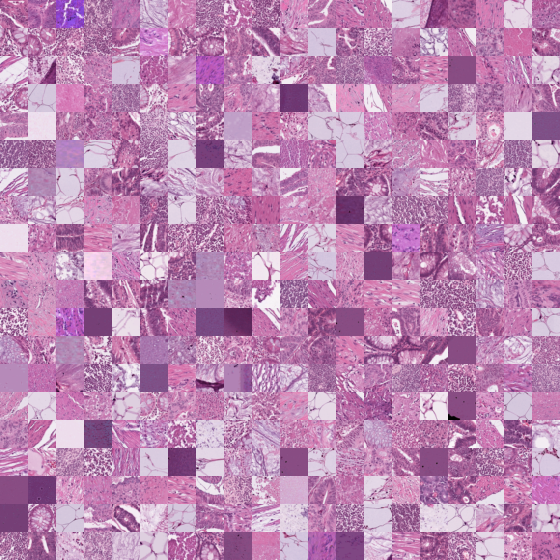

In [8]:
# montage

train_dataset.montage(length=20)

## ResNet18

In [9]:
from torchvision.models import resnet18

model = resnet18(num_classes=n_classes)

# WAJIB untuk 28x28
model.conv1 = nn.Conv2d(n_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

print(criterion)

CrossEntropyLoss()


In [10]:
import os, random
import numpy as np
import torch

def make_reproducible(seed=42):
    # 1) Seed semua RNG
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # 2) Paksa operasi deterministik (GPU)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

    # 3) CUBLAS deterministic (penting untuk beberapa operasi matmul di CUDA)
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

make_reproducible(42)


In [11]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)


In [12]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 704/704 [16:06<00:00,  1.37s/it]


In [13]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.992  acc:0.873
test  auc: 0.956  acc:0.778


In [14]:
import matplotlib.pyplot as plt

labels = train_dataset.labels.squeeze()

In [15]:
unique, counts = np.unique(labels, return_counts=True)

In [16]:
import matplotlib.pyplot as plt

labels = train_dataset.labels.squeeze()
unique, counts = np.unique(labels, return_counts=True)

class_counts = dict(zip(unique, counts))
print(class_counts)

class_names = [info['label'][str(i)] for i in unique]

{0: 9366, 1: 9509, 2: 10360, 3: 10401, 4: 8006, 5: 12182, 6: 7886, 7: 9401, 8: 12885}


{0: 9366, 1: 9509, 2: 10360, 3: 10401, 4: 8006, 5: 12182, 6: 7886, 7: 9401, 8: 12885}


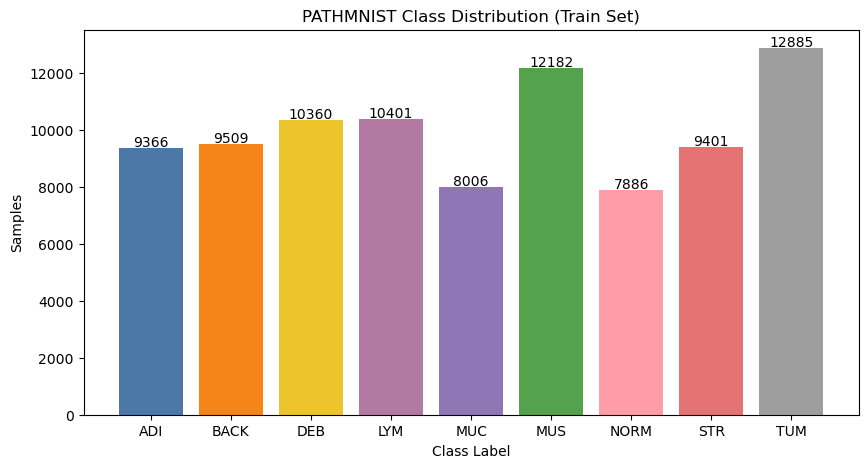

In [17]:
import matplotlib.pyplot as plt

labels = train_dataset.labels.squeeze()
unique, counts = np.unique(labels, return_counts=True)

class_counts = dict(zip(unique, counts))
print(class_counts)

class_names = [info['label'][str(i)] for i in unique]

label_map = {
    'adipose': 'ADI',
    'background': 'BACK',
    'debris': 'DEB',
    'lymphocytes': 'LYM',
    'mucus': 'MUC',
    'smooth muscle': 'MUS',
    'normal colon mucosa': 'NORM',
    'cancer-associated stroma': 'STR',
    'colorectal adenocarcinoma epithelium': 'TUM'
}

short_labels = [label_map[l] for l in class_names]

colors = [
    '#4C78A8',  # biru - ADI
    '#F58518',  # oranye - BACK
    '#EEC42D',  # kuning - DEB
    '#B279A2',  # ungu muda - LYM
    '#8F77B5',  # ungu - MUC
    '#54A24B',  # hijau - MUS
    '#FF9DA6',   # pink - NORM
    '#E57373',  # merah - STR 
    '#9E9E9E',   # abu-abu - TUM 
]

plt.figure(figsize=(10,5))
plt.bar(short_labels, counts, color=colors)
plt.xlabel("Class Label")
plt.ylabel("Samples")
plt.title("PATHMNIST Class Distribution (Train Set)")

# Tampilkan angka di atas bar
for i, v in enumerate(counts):
    plt.text(i, v + 50, str(v), ha='center')

plt.show()

{0: 1338, 1: 847, 2: 339, 3: 634, 4: 1035, 5: 592, 6: 741, 7: 421, 8: 1233}


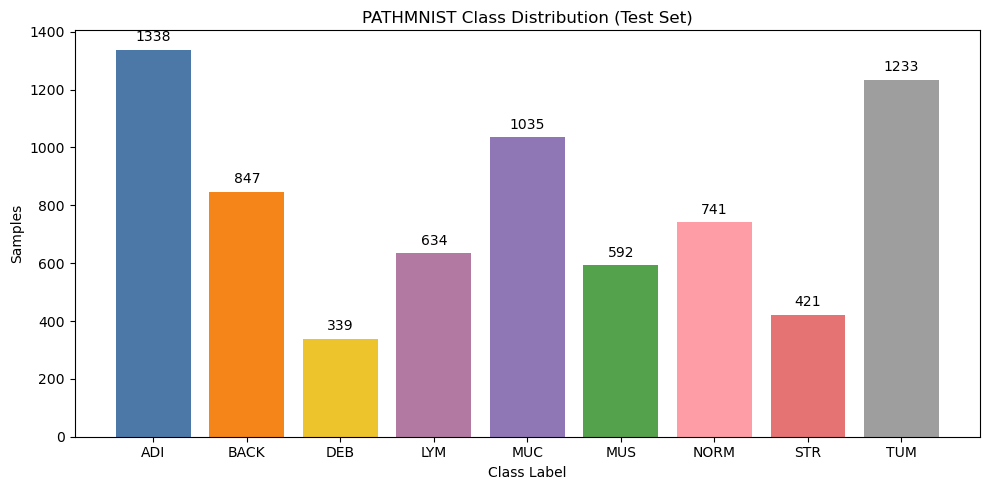

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Data
label_test = test_dataset.labels.squeeze()
unique_test, counts_test = np.unique(label_test, return_counts=True)

class_counts = dict(zip(unique_test, counts_test))
print(class_counts)

class_names = [info['label'][str(i)] for i in unique_test]

label_map = {
    'adipose': 'ADI',
    'background': 'BACK',
    'debris': 'DEB',
    'lymphocytes': 'LYM',
    'mucus': 'MUC',
    'smooth muscle': 'MUS',
    'normal colon mucosa': 'NORM',
    'cancer-associated stroma': 'STR',
    'colorectal adenocarcinoma epithelium': 'TUM'
}

short_labels = [label_map[l] for l in class_names]

colors = [
    '#4C78A8',  # biru - ADI
    '#F58518',  # oranye - BACK
    '#EEC42D',  # kuning - DEB
    '#B279A2',  # ungu muda - LYM
    '#8F77B5',  # ungu - MUC
    '#54A24B',  # hijau - MUS
    '#FF9DA6',   # pink - NORM
    '#E57373',  # merah - STR 
    '#9E9E9E',   # abu-abu - TUM 
]

# Plotting
plt.figure(figsize=(10,5))
bars = plt.bar(short_labels, counts_test, color=colors)
plt.xlabel("Class Label")
plt.ylabel("Samples")
plt.title("PATHMNIST Class Distribution (Test Set)")

# Menambahkan angka di atas bar, menyesuaikan posisi agar tidak keluar
for i, v in enumerate(counts_test):
    plt.text(i, v + 20, str(v), ha='center', va='bottom', fontsize=10)

plt.tight_layout()  # Memastikan layout tidak terpotong
plt.show()


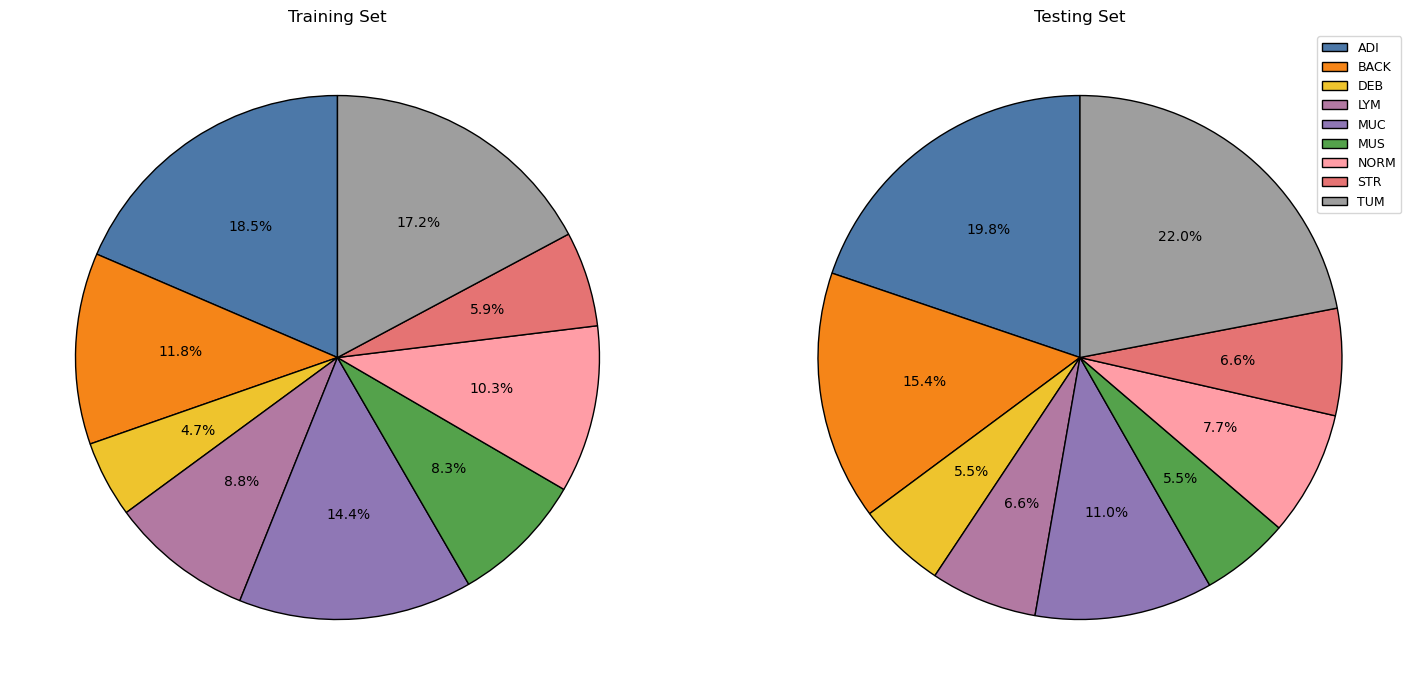

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Data untuk pie chart
labels = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
counts_train = [1330, 847, 339, 634, 1035, 592, 741, 421, 1233]  # Contoh distribusi data train
counts_test = [180, 140, 50, 60, 100, 50, 70, 60, 200]  # Contoh distribusi data test

# Warna untuk masing-masing kelas
colors = [
    '#4C78A8',  # biru - ADI
    '#F58518',  # oranye - BACK
    '#EEC42D',  # kuning - DEB
    '#B279A2',  # ungu muda - LYM
    '#8F77B5',  # ungu - MUC
    '#54A24B',  # hijau - MUS
    '#FF9DA6',  # pink - NORM
    '#E57373',  # merah - STR 
    '#9E9E9E',  # abu-abu - TUM
]

# Hitung jumlah gambar dari dataset yang ada
train_size = len(train_dataset)  # Bisa diganti dengan test_dataset untuk testing set
test_size = len(test_dataset)    # Menyesuaikan dengan jumlah gambar di testing set

# Membuat pie chart untuk train data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Pie chart untuk training set
ax1.pie(counts_train, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'}, labels=None)
# ax1.set_title(f"Training Set ({train_size:,} images)")  # Menampilkan jumlah gambar secara dinamis
ax1.set_title(f"Training Set") 

# Pie chart untuk testing set
ax2.pie(counts_test, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'}, labels=None)
# ax2.set_title(f"Testing Set ({test_size:,} images)")  # Menampilkan jumlah gambar secara dinamis
ax2.set_title(f"Testing Set")

# Menambahkan legenda
plt.legend(labels, loc="best", fontsize=9)

# Menampilkan plot
plt.tight_layout()
plt.show()


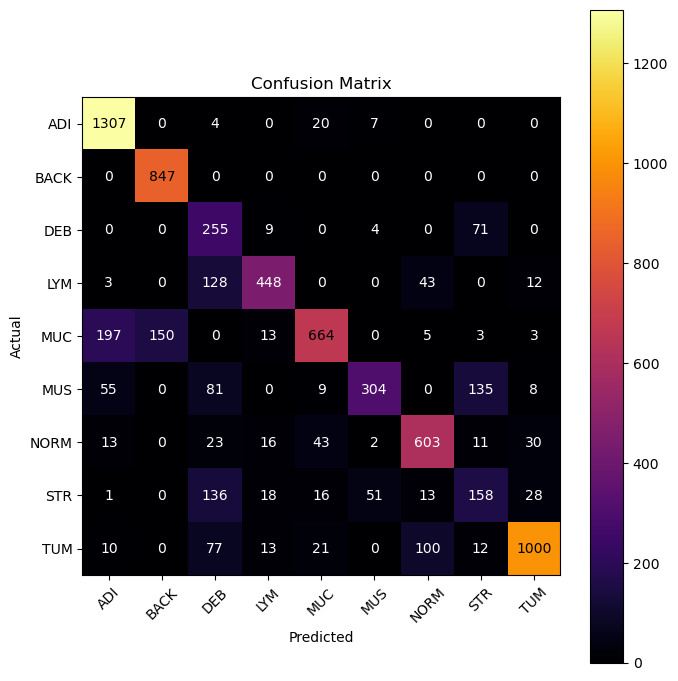

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Label untuk kelas
class_labels = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(DEVICE)

all_preds = []
all_targets = []

# Evaluasi model
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(DEVICE)
        targets = targets.squeeze().long().to(DEVICE)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Membuat confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Hitung akurasi
accuracy = np.trace(cm) / np.sum(cm) * 100

# Plot confusion matrix dengan colormap 'inferno' (lebih gelap)
plt.figure(figsize=(7,7))
plt.imshow(cm, interpolation='nearest', cmap='inferno')  # Gunakan 'inferno' untuk warna gelap
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Menambahkan label huruf di sumbu x dan y
plt.xticks(np.arange(9), class_labels, rotation=45)
plt.yticks(np.arange(9), class_labels)

# Menambahkan angka ke dalam confusion matrix dengan warna teks disesuaikan
for i in range(9):
    for j in range(9):
        # Tentukan warna teks berdasarkan nilai
        text_color = "white" if cm[i, j] < np.max(cm) / 2 else "black"
        plt.text(j, i, cm[i, j], ha='center', va='center', color=text_color)

# Menambahkan colorbar
plt.colorbar()

# Mengatur layout dan menampilkan plot
plt.tight_layout()
plt.show()

=== Per-Class Performance Metrics (Test Set) ===
Class  Precision  Recall  F1-Score  Support
  ADI     0.8241  0.9768    0.8940     1338
 BACK     0.8495  1.0000    0.9187      847
  DEB     0.3622  0.7522    0.4890      339
  LYM     0.8665  0.7066    0.7785      634
  MUC     0.8590  0.6415    0.7345     1035
  MUS     0.8261  0.5135    0.6333      592
 NORM     0.7893  0.8138    0.8013      741
  STR     0.4051  0.3753    0.3896      421
  TUM     0.9251  0.8110    0.8643     1233

=== Overall Metrics ===
Accuracy            : 0.7780
Macro Precision     : 0.7452
Macro Recall        : 0.7323
Macro F1            : 0.7226
Weighted Precision  : 0.8034
Weighted Recall     : 0.7780
Weighted F1         : 0.7789


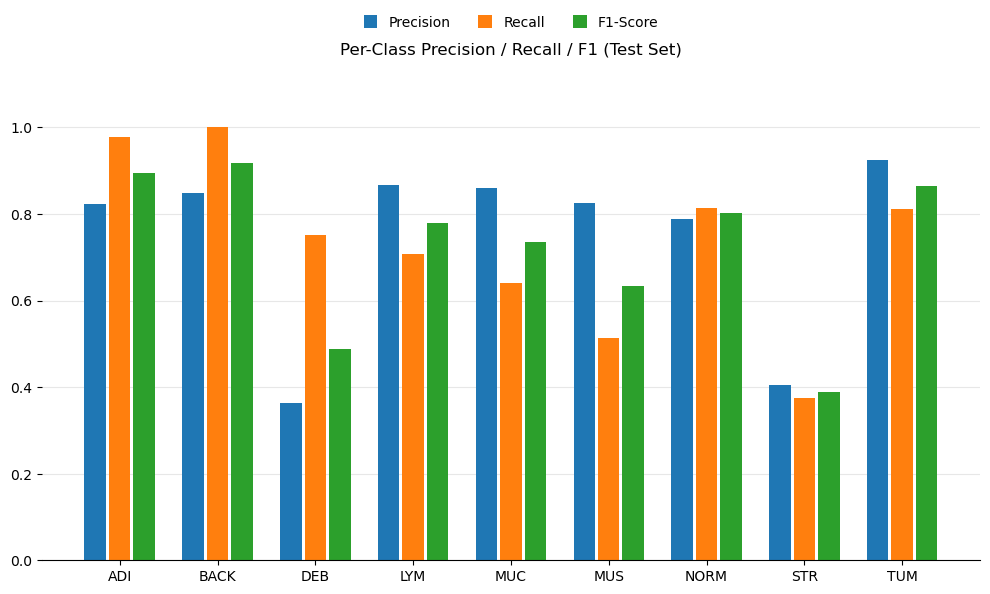

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# all_targets = [...]
# all_preds   = [...]
# class_labels = ['ADI','BACK','DEB','LYM','MUC','MUS','NORM','STR','TUM']

y_true = np.array(all_targets)
y_pred = np.array(all_preds)
labels = class_labels

# 1) Accuracy overall
acc = accuracy_score(y_true, y_pred)

# 2) Precision/Recall/F1 per kelas
precision, recall, f1, support = precision_recall_fscore_support(
    y_true,
    y_pred,
    labels=np.arange(len(labels)),
    average=None,
    zero_division=0  # biar aman kalau ada kelas yg tidak keprediksi sama sekali
)

# 3) (Opsional tapi bagus) macro & weighted average
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro', zero_division=0
)
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted', zero_division=0
)

# 4) Tabel metrik
df_metrics = pd.DataFrame({
    'Class': labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("=== Per-Class Performance Metrics (Test Set) ===")
print(df_metrics.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

print("\n=== Overall Metrics ===")
print(f"Accuracy            : {acc:.4f}")
print(f"Macro Precision     : {precision_macro:.4f}")
print(f"Macro Recall        : {recall_macro:.4f}")
print(f"Macro F1            : {f1_macro:.4f}")
print(f"Weighted Precision  : {precision_weighted:.4f}")
print(f"Weighted Recall     : {recall_weighted:.4f}")
print(f"Weighted F1         : {f1_weighted:.4f}")

# =================
# VISUALISASI BAR
# =================
x = np.arange(len(labels))
width = 0.22
offset = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

# (Kalau kamu mau tetap tema gelap seperti confusion matrix)
# ganti cmap inferno tadi -> di bar chart bisa pakai dark background juga:
# plt.style.use('dark_background')  # optional

rects1 = ax.bar(x - offset, precision, width, label='Precision')
rects2 = ax.bar(x,         recall,    width, label='Recall')
rects3 = ax.bar(x + offset, f1,       width, label='F1-Score')

ax.set_title("Per-Class Precision / Recall / F1 (Test Set)")
ax.set_ylim(0, 1.15)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0)
ax.yaxis.grid(True, linestyle='-', alpha=0.3)
ax.set_axisbelow(True)

for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)

ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.12),
    ncol=3,
    frameon=False,
    handlelength=1.0,
    handleheight=1.0
)

plt.tight_layout()
plt.show()

# # =========================
# # (BONUS) Grafik accuracy overall (single bar)
# # =========================
# plt.figure(figsize=(4, 4))
# plt.bar(["Accuracy"], [acc])
# plt.ylim(0, 1.0)
# plt.title("Overall Accuracy (Test Set)")
# plt.grid(axis='y', alpha=0.3)
# plt.tight_layout()
# plt.show()

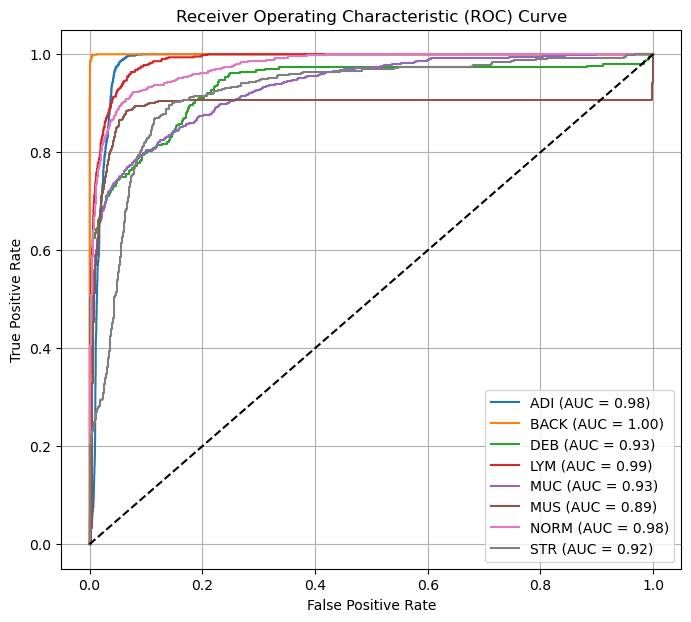

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

model.eval()

all_probs = []
all_true = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_true.append(targets.squeeze().cpu().numpy())

# Gabungkan semua batch
y_score = np.vstack(all_probs)      # shape [N, 7]
y_true = np.hstack(all_true)       # shape [N]

# One-vs-Rest binarization
n_classes = 8
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

labels = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']

plt.figure(figsize=(8,7))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # garis diagonal random

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']
(89996, 28, 28, 3)
(89996,)


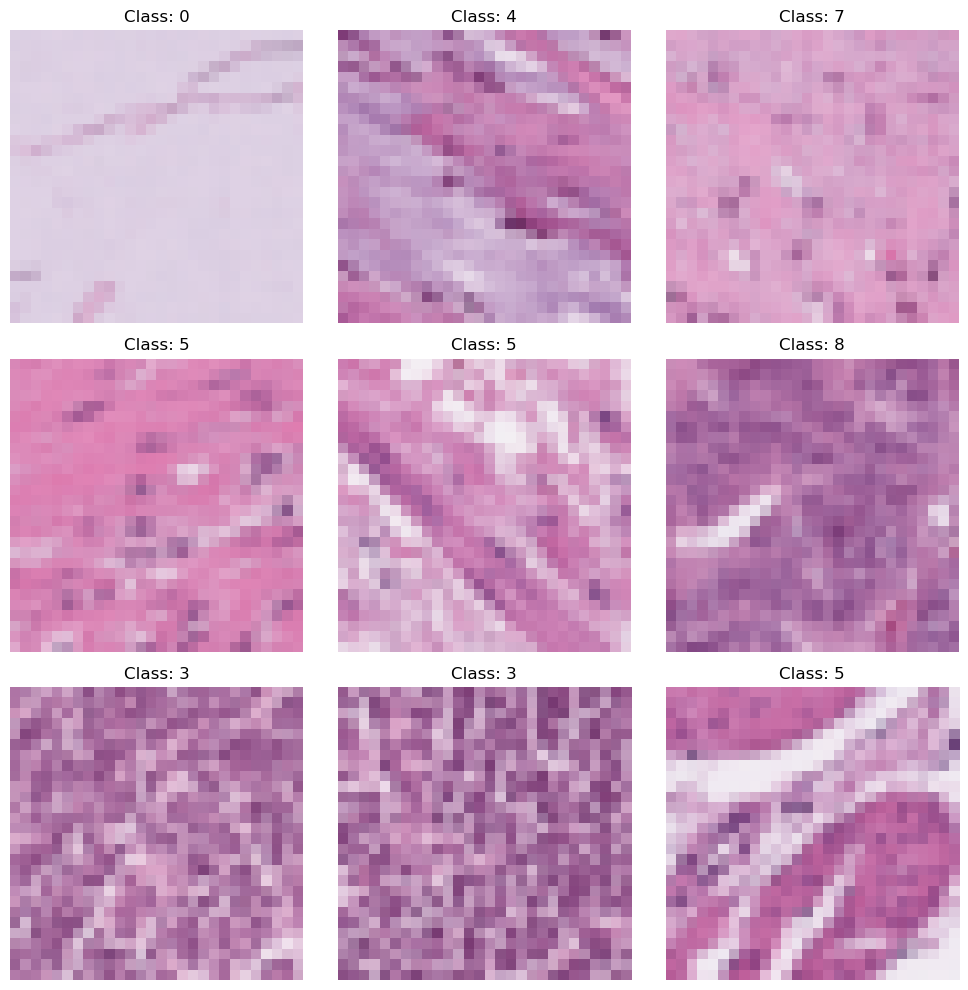

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Memuat file pathmnist.npz
file_path = 'D:/21266 Shinta Febriana/Kuliah/pathmnist.npz'  # Ganti dengan path file yang sesuai
data = np.load(file_path)

# Menampilkan kunci yang ada di dalam file .npz
print(data.files)

# Mengambil gambar dan label untuk testing set
images = data['train_images']  # Gambar dari test set
labels = data['train_labels'].squeeze()  # Label dari test set, squeeze untuk 1D array

# Menampilkan bentuk data
print(images.shape)  # Harus berupa [jumlah_sampel, 28, 28, 3]
print(labels.shape)  # Harus sesuai dengan jumlah gambar

# Menampilkan gambar
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Menampilkan 9 gambar pertama
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])  # Menampilkan gambar yang sudah dalam format [height, width, channels]
    ax.set_title(f'Class: {labels[i]}', fontsize=12, color='black')  # Menambahkan label kelas
    ax.axis('off')  # Menonaktifkan sumbu

plt.tight_layout()
plt.show()

(7180, 28, 28, 3)
(7180,)


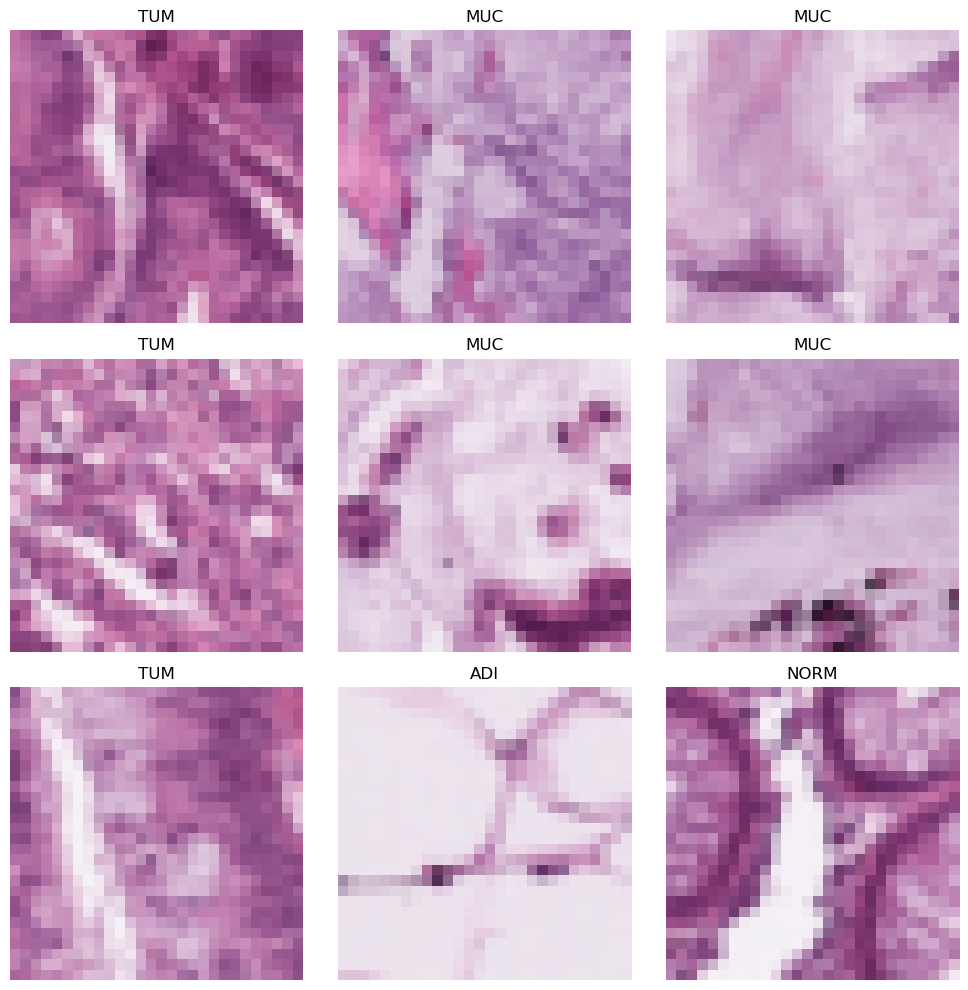

In [24]:
# Mengambil gambar dan label untuk testing set
images = data['test_images']  # Gambar dari test set
labels = data['test_labels'].squeeze()  # Label dari test set, squeeze untuk 1D array

# Menampilkan bentuk data
print(images.shape)  # Harus berupa [jumlah_sampel, 28, 28, 3]
print(labels.shape)  # Harus sesuai dengan jumlah gambar

# Label panjang dan label singkat
label_map = {
    'adipose': 'ADI',
    'background': 'BACK',
    'debris': 'DEB',
    'lymphocytes': 'LYM',
    'mucus': 'MUC',
    'smooth muscle': 'MUS',
    'normal colon mucosa': 'NORM',
    'cancer-associated stroma': 'STR',
    'colorectal adenocarcinoma epithelium': 'TUM'
}

# Mapping dari angka ke nama panjang
long_label_map = {
    0: 'adipose',
    1: 'background',
    2: 'debris',
    3: 'lymphocytes',
    4: 'mucus',
    5: 'smooth muscle',
    6: 'normal colon mucosa',
    7: 'cancer-associated stroma',
    8: 'colorectal adenocarcinoma epithelium'
}

# Menampilkan gambar
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Menampilkan 9 gambar pertama
for i, ax in enumerate(axes.flat):
    # Mendapatkan label panjang dari angka label
    long_label = long_label_map[labels[i]]
    # Mendapatkan label singkat dari label panjang
    short_label = label_map[long_label]

    ax.imshow(images[i])  # Menampilkan gambar
    ax.set_title(f'{short_label}', fontsize=12, color='black')  # Menambahkan label kelas yang disingkat
    ax.axis('off')  # Menonaktifkan sumbu

plt.tight_layout()
plt.show()

raw training data

In [8]:
from medmnist import PathMNIST
from torchvision import transforms

# Transform
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load dataset
train_dataset = PathMNIST(split='train', transform=transform, download=True)
test_dataset  = PathMNIST(split='test', transform=transform, download=True)

# Ambil sample
image, label = train_dataset[0]

print(image.shape)  # torch.Size([3, 28, 28])
print(label)        # tensor([kelas])


c:\Users\Dhanang Listyo W\anaconda3\envs\visualisasi_analitik\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Using downloaded and verified file: C:\Users\Dhanang Listyo W\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\Dhanang Listyo W\.medmnist\pathmnist.npz
torch.Size([3, 28, 28])
[0]


raw test data

In [10]:
from medmnist import PathMNIST
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

# Load test dataset
test_dataset = PathMNIST(split='test', transform=transform, download=True)

# Ambil numpy array
images = test_dataset.imgs          # shape: (7180, 28, 28, 3)
labels = test_dataset.labels.squeeze()  # shape: (7180,)

print(images.shape)
print(labels.shape)


Using downloaded and verified file: C:\Users\Dhanang Listyo W\.medmnist\pathmnist.npz
(7180, 28, 28, 3)
(7180,)


raw data

In [12]:
from medmnist import PathMNIST
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = PathMNIST(split='train', transform=transform, download=True)
test_dataset  = PathMNIST(split='test', transform=transform, download=True)

import numpy as np

images = train_dataset.imgs                  # (89996, 28, 28, 3)
labels = train_dataset.labels.squeeze()      # (89996,)

print(images.shape)
print(labels.shape)

X = images.reshape(images.shape[0], -1)  # (N, 2352)
y = labels


Using downloaded and verified file: C:\Users\Dhanang Listyo W\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\Dhanang Listyo W\.medmnist\pathmnist.npz
(89996, 28, 28, 3)
(89996,)


t-sne dengan resnet (training set)

In [15]:
def extract_features(data_loader):
    all_features = []
    all_labels = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)

            targets_np = targets.view(-1).cpu().numpy()

            feats = feature_extractor(inputs)
            feats = feats.view(feats.size(0), -1)
            feats = feats.cpu().numpy()

            all_features.append(feats)
            all_labels.append(targets_np)

    X = np.concatenate(all_features, axis=0)
    y = np.concatenate(all_labels, axis=0)
    return X, y


t-sne raw test data

In [17]:
# Ambil data test dari MedMNIST
images = test_dataset.imgs                 # (7180, 28, 28, 3)
labels = test_dataset.labels.squeeze()     # (7180,)

print(images.shape)
print(labels.shape)


(7180, 28, 28, 3)
(7180,)


t sne resnet test data

In [19]:
from torch.utils.data import DataLoader
from medmnist import PathMNIST
from torchvision import transforms

# transform khusus evaluasi (tanpa augmentasi)
transform_eval = transforms.Compose([
    transforms.ToTensor()
])

# test dataset
test_dataset = PathMNIST(
    split='test',
    transform=transform_eval,
    download=True
)

# test loader
test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=2
)


Using downloaded and verified file: C:\Users\Dhanang Listyo W\.medmnist\pathmnist.npz


raw data

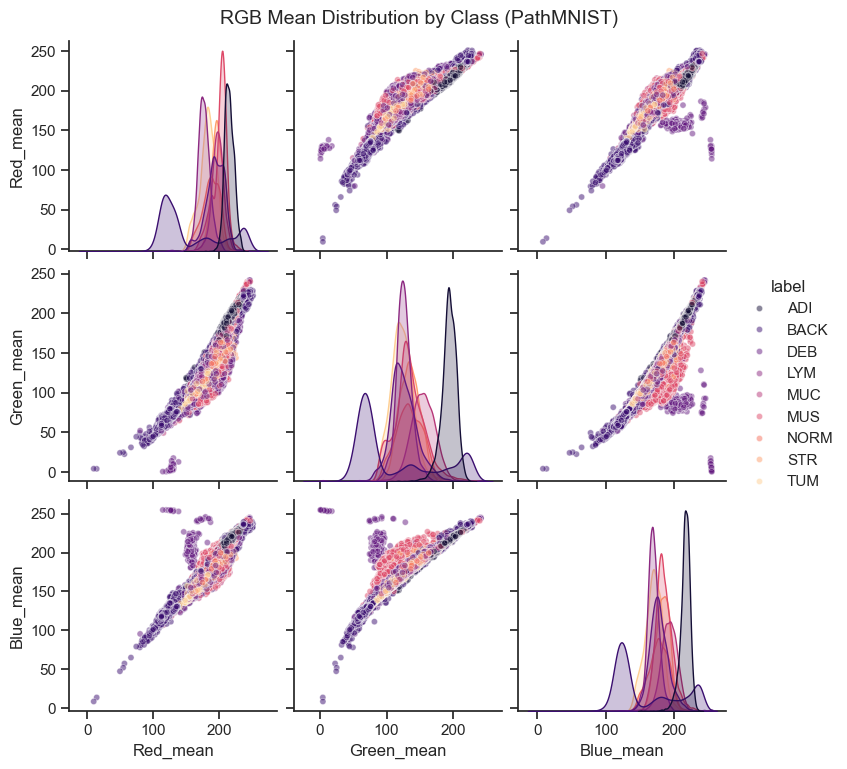

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1) ambil data
images = train_dataset.imgs
labels = train_dataset.labels.flatten()

# 2) hitung mean RGB
rgb_means = images.mean(axis=(1, 2))
df = pd.DataFrame(rgb_means, columns=['Red_mean', 'Green_mean', 'Blue_mean'])

# 3) mapping label angka -> nama pendek (ADI, BACK, ...)
short_label_by_id = {
    0: 'ADI',
    1: 'BACK',
    2: 'DEB',
    3: 'LYM',
    4: 'MUC',
    5: 'MUS',
    6: 'NORM',
    7: 'STR',
    8: 'TUM'
}

df['label'] = pd.Series(labels).map(short_label_by_id)

# (opsional) urutin legend biar rapi
order = ['ADI','BACK','DEB','LYM','MUC','MUS','NORM','STR','TUM']
df['label'] = pd.Categorical(df['label'], categories=order, ordered=True)

# 4) plot
sns.set_theme(style="ticks")
g = sns.pairplot(
    df,
    hue='label',
    palette='magma',
    diag_kind='kde',
    plot_kws={'alpha': 0.5, 's': 20, 'edgecolor': 'w', 'linewidth': 0.5},
    diag_kws={'fill': True}
)

g.fig.suptitle("RGB Mean Distribution by Class (PathMNIST)", y=1.02, fontsize=14)
plt.show()


In [21]:
custom_palette = {
    'ADI':  '#FF0000',  # merah terang
    'BACK': '#00FF00',  # hijau neon
    'DEB':  '#0000FF',  # biru terang
    'LYM':  '#FFD700',  # kuning emas
    'MUC':  '#FF00FF',  # magenta
    'MUS':  '#00FFFF',  # cyan
    'NORM': '#FF8C00',  # oranye terang
    'STR':  '#9400D3',  # ungu tajam
    'TUM':  '#00BFFF'   # biru langit terang
}


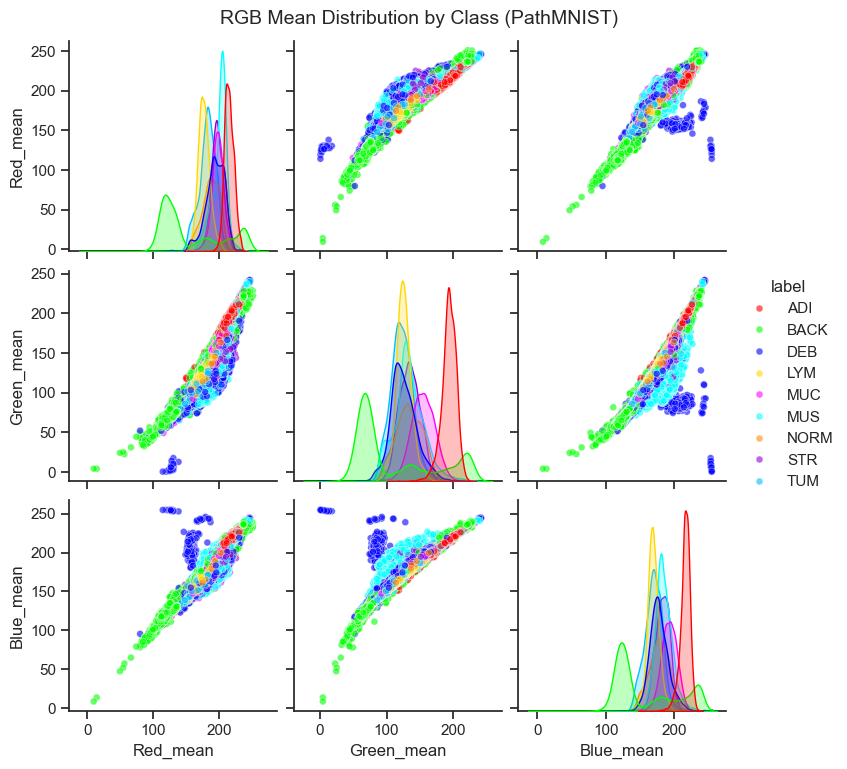

In [22]:
g = sns.pairplot(
    df,
    hue='label',
    palette=custom_palette,
    diag_kind='kde',
    plot_kws={'alpha': 0.6, 's': 25},
    diag_kws={'fill': True}
)
g.fig.suptitle("RGB Mean Distribution by Class (PathMNIST)", y=1.02, fontsize=14)
plt.show()


RGB untuk test data. 
Namun, karena RGB ini untuk EDA, maka tidak perlu pakai data test

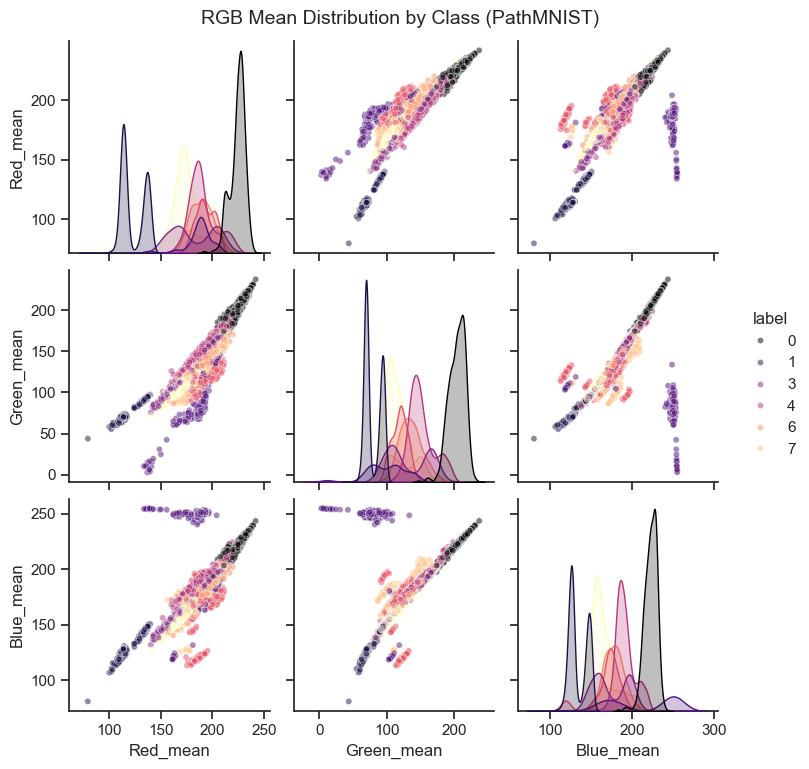

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Hitung rata-rata R, G, B untuk setiap gambar
# Asumsi train_dataset.imgs memiliki shape (N, 28, 28, 3)
images = test_dataset.imgs
labels = test_dataset.labels.flatten()

# Hitung rata-rata pixel pada sumbu (axis) 1 dan 2 (H dan W)
# Hasilnya adalah array dengan shape (N, 3) -> [Mean_R, Mean_G, Mean_B]
rgb_means = images.mean(axis=(1, 2))

# 2. Masukkan ke dalam Pandas DataFrame
df = pd.DataFrame(rgb_means, columns=['Red_mean', 'Green_mean', 'Blue_mean'])
df['label'] = labels

# 3. Buat Pair Plot menggunakan Seaborn
# 'hue' digunakan untuk membedakan warna berdasarkan label
# 'palette' rocket/magma memberikan kesan gelap yang elegan seperti di gambar
sns.set_theme(style="ticks")
g = sns.pairplot(
    df, 
    hue='label', 
    palette='magma', 
    diag_kind='kde', # Menampilkan kurva distribusi di diagonal
    plot_kws={'alpha': 0.5, 's': 20, 'edgecolor': 'w', 'linewidth': 0.5},
    diag_kws={'fill': True}
)

# Menambahkan judul
g.fig.suptitle("RGB Mean Distribution by Class (PathMNIST)", y=1.02, fontsize=14)

plt.show()

boxplot

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

images = train_dataset.imgs
labels = train_dataset.labels.flatten()

# Hitung rata-rata seluruh pixel (R,G,B digabung)
mean_intensity = images.mean(axis=(1,2,3))

df_intensity = pd.DataFrame({
    "Mean_Intensity": mean_intensity,
    "label": labels
})

# mapping angka ke nama pendek
short_label_by_id = {
    0: 'ADI',
    1: 'BACK',
    2: 'DEB',
    3: 'LYM',
    4: 'MUC',
    5: 'MUS',
    6: 'NORM',
    7: 'STR',
    8: 'TUM'
}

df_intensity["label"] = df_intensity["label"].map(short_label_by_id)


C:\Users\Dhanang Listyo W\AppData\Local\Temp\ipykernel_17784\2463470809.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


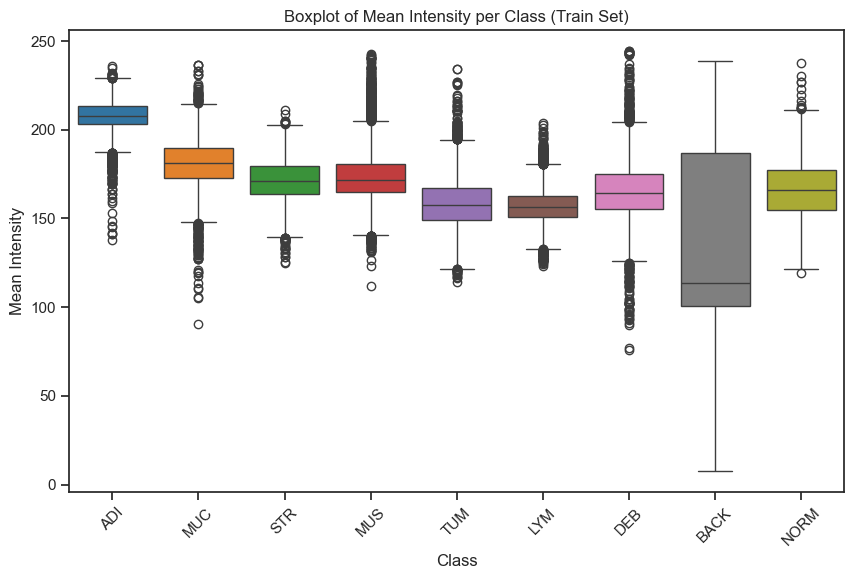

In [26]:
plt.figure(figsize=(10,6))

sns.boxplot(
    data=df_intensity,
    x="label",
    y="Mean_Intensity",
    palette="tab10"
)

plt.title("Boxplot of Mean Intensity per Class (Train Set)")
plt.xlabel("Class")
plt.ylabel("Mean Intensity")
plt.xticks(rotation=45)
plt.show()


Boxplot Confidence Score per Class

In [29]:
from torch.utils.data import DataLoader
from medmnist import PathMNIST
from torchvision import transforms

# transform evaluasi (TANPA augmentasi)
transform_eval = transforms.Compose([
    transforms.ToTensor()
])

# dataset train (untuk evaluasi / confidence analysis)
train_dataset_at_eval = PathMNIST(
    split='train',
    transform=transform_eval,
    download=True
)

# loader train (tanpa shuffle)
train_loader_at_eval = DataLoader(
    train_dataset_at_eval,
    batch_size=128,
    shuffle=False,
    num_workers=2
)
y_true, y_conf, y_pred = collect_confidence_scores(train_loader_at_eval)


Using downloaded and verified file: C:\Users\Dhanang Listyo W\.medmnist\pathmnist.npz


Boxplot confidence untuk prediksi BENAR vs SALAH per kelas

In [30]:
# Tandai apakah prediksi benar atau salah
correct_mask = (y_true == y_pred)

df_conf_detailed = pd.DataFrame({
    "True_Class": [short_label_by_id[i] for i in y_true],
    "Confidence": y_conf,
    "Prediction_Status": np.where(correct_mask, "Correct", "Wrong")
})

order = ['ADI','BACK','DEB','LYM','MUC','MUS','NORM','STR','TUM']
df_conf_detailed["True_Class"] = pd.Categorical(
    df_conf_detailed["True_Class"],
    categories=order,
    ordered=True
)


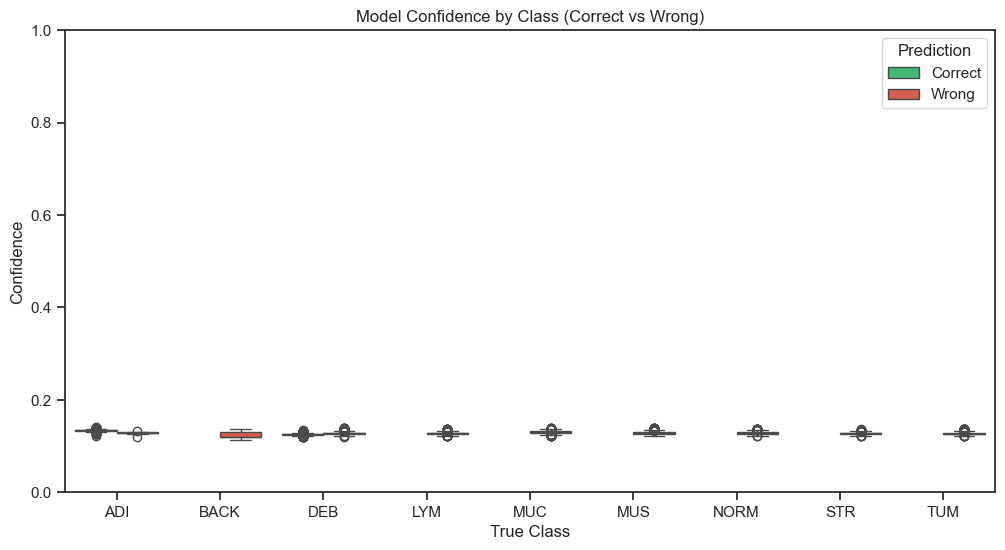

In [31]:
plt.figure(figsize=(12,6))

sns.boxplot(
    data=df_conf_detailed,
    x="True_Class",
    y="Confidence",
    hue="Prediction_Status",
    palette={"Correct": "#2ECC71", "Wrong": "#E74C3C"}
)

plt.title("Model Confidence by Class (Correct vs Wrong)")
plt.xlabel("True Class")
plt.ylabel("Confidence")
plt.ylim(0,1)
plt.legend(title="Prediction")
plt.show()


violin EDA

C:\Users\Dhanang Listyo W\AppData\Local\Temp\ipykernel_17784\2127642361.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


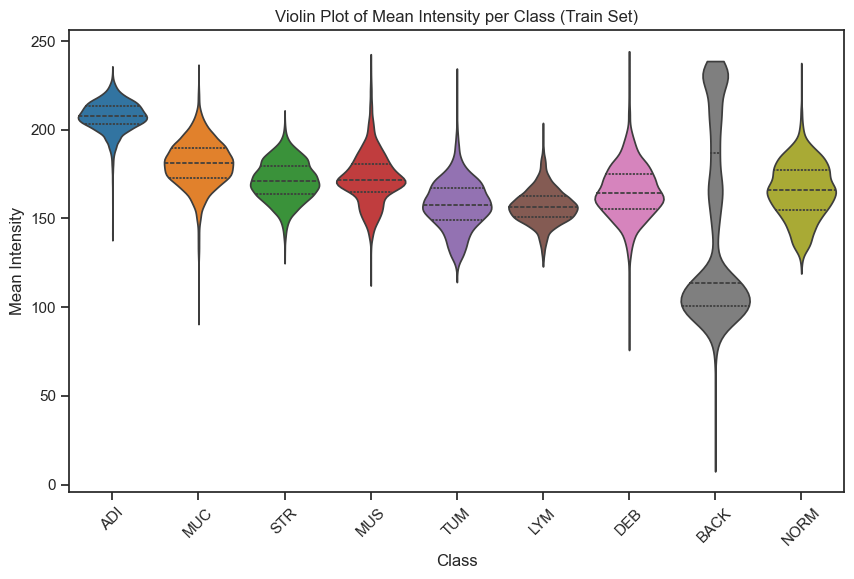

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

sns.violinplot(
    data=df_intensity,
    x="label",
    y="Mean_Intensity",
    palette="tab10",
    inner="quartile",   # garis quartile di dalam violin
    cut=0               # biar violin tidak “melebar” melewati range data
)

plt.title("Violin Plot of Mean Intensity per Class (Train Set)")
plt.xlabel("Class")
plt.ylabel("Mean Intensity")
plt.xticks(rotation=45)
plt.show()


Violin Confidence per Class

C:\Users\Dhanang Listyo W\AppData\Local\Temp\ipykernel_17784\4118252045.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


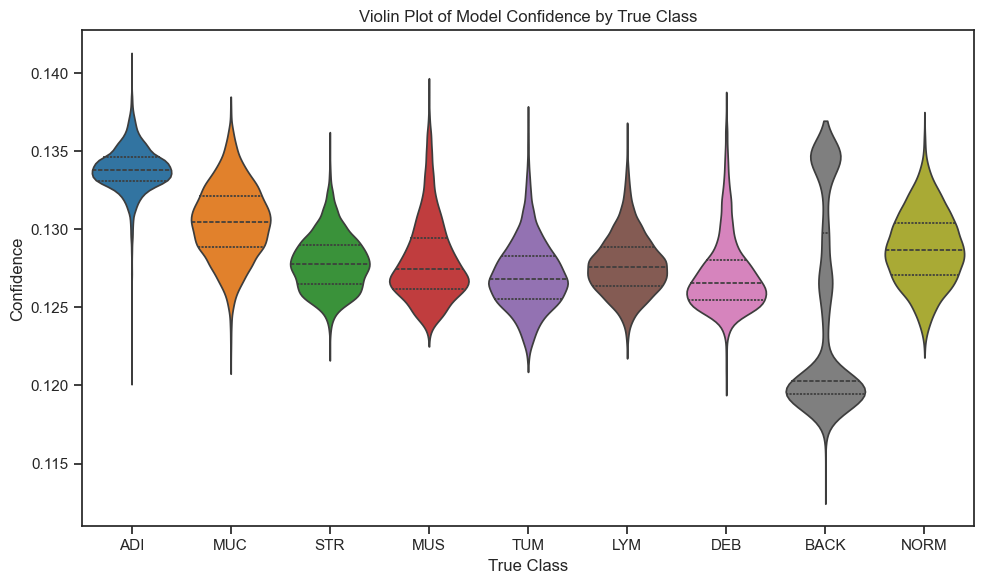

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_conf = pd.DataFrame({
    "True_Class": [short_label_by_id[i] for i in y_true],
    "Confidence": y_conf
})

plt.figure(figsize=(10,6))

sns.violinplot(
    data=df_conf,
    x="True_Class",
    y="Confidence",
    palette="tab10",
    inner="quartile",
    cut=0
)

plt.title("Violin Plot of Model Confidence by True Class")
plt.xlabel("True Class")
plt.ylabel("Confidence")
plt.tight_layout()
plt.show()


Violin Split Correct vs Wrong

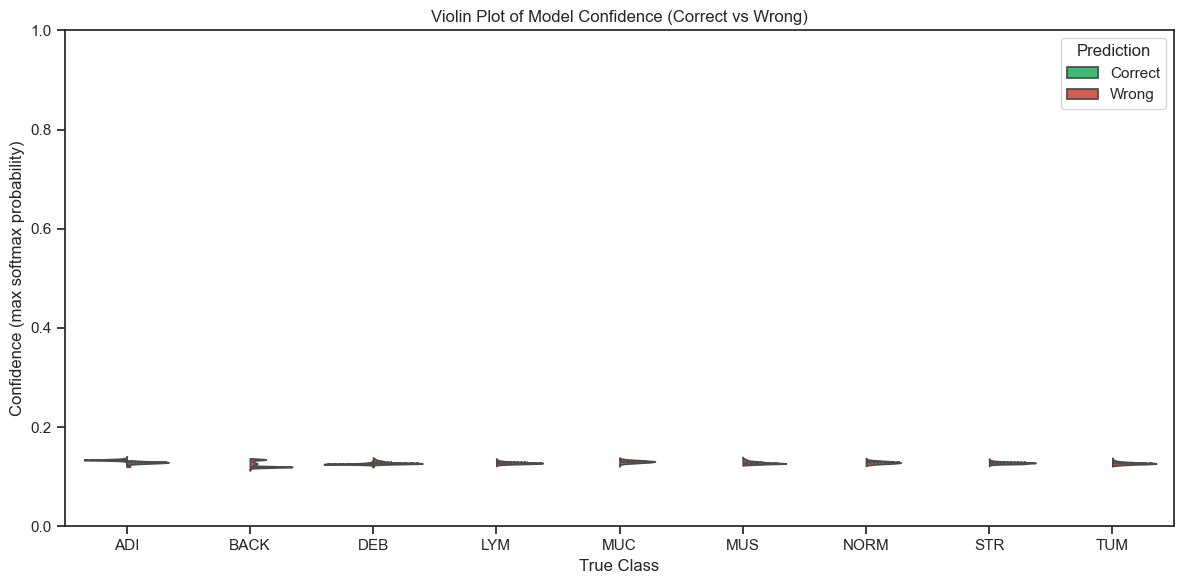

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

sns.violinplot(
    data=df_conf_detailed,
    x="True_Class",
    y="Confidence",
    hue="Prediction_Status",
    split=True,  # penting untuk pisah kiri-kanan
    palette={"Correct": "#2ECC71", "Wrong": "#E74C3C"},
    inner="quartile",
    cut=0
)

plt.title("Violin Plot of Model Confidence (Correct vs Wrong)")
plt.xlabel("True Class")
plt.ylabel("Confidence (max softmax probability)")
plt.ylim(0,1)
plt.legend(title="Prediction")
plt.tight_layout()
plt.show()


tujuan: Apakah brightness (mean intensity) benar-benar berkorelasi kuat dengan prediksi BACK?

In [36]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from scipy.stats import pointbiserialr

device = next(model.parameters()).device
model.eval()

all_intensity = []
all_pred_back = []

with torch.no_grad():
    for inputs, targets in train_loader_at_eval:
        inputs = inputs.to(device)

        # Hitung brightness
        intensity = inputs.mean(dim=(1,2,3)).cpu().numpy()

        # Prediksi model
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        pred = torch.argmax(probs, dim=1).cpu().numpy()

        # Apakah diprediksi sebagai BACK (label 1)
        pred_back = (pred == 1).astype(int)

        all_intensity.append(intensity)
        all_pred_back.append(pred_back)

mean_intensity = np.concatenate(all_intensity)
pred_back_flag = np.concatenate(all_pred_back)


In [37]:
corr, p_value = pointbiserialr(pred_back_flag, mean_intensity)

print("Correlation between Mean Intensity and Prediction=BACK:", round(corr, 4))
print("p-value:", p_value)


Correlation between Mean Intensity and Prediction=BACK: nan
p-value: nan


c:\Users\Dhanang Listyo W\anaconda3\envs\visualisasi_analitik\lib\site-packages\scipy\stats\_stats_py.py:5546: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


Kalau boxplot beda jauh → brightness kuat pengaruhnya.

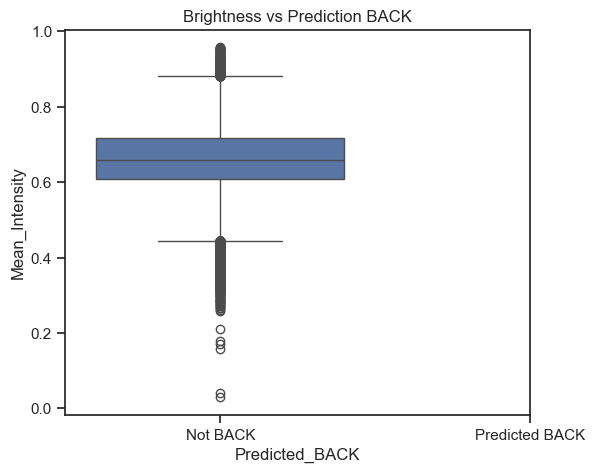

In [38]:
df_check = pd.DataFrame({
    "Mean_Intensity": mean_intensity,
    "Predicted_BACK": pred_back_flag
})

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.boxplot(data=df_check, x="Predicted_BACK", y="Mean_Intensity")
plt.xticks([0,1], ["Not BACK", "Predicted BACK"])
plt.title("Brightness vs Prediction BACK")
plt.show()


membuktikan

In [39]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# ====== set label id ======
ADI_ID = 0
MUC_ID = 5

short_label_by_id = {
    0: 'ADI', 1: 'BACK', 2: 'DEB', 3: 'LYM', 4: 'MUC',
    5: 'MUS', 6: 'NORM', 7: 'STR', 8: 'TUM'
}

device = next(model.parameters()).device
model.eval()

def show_misclassified(true_id, pred_id, data_loader, max_show=25, cols=5):
    imgs_to_show = []
    infos = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.squeeze().long().to(device)

            logits = model(inputs)                  # (B, 9)
            probs = F.softmax(logits, dim=1)        # (B, 9)
            conf, pred = probs.max(dim=1)           # (B,), (B,)

            # mask: true = true_id AND pred = pred_id
            mask = (targets == true_id) & (pred == pred_id)
            if mask.any():
                sel_inputs = inputs[mask].cpu()
                sel_probs  = probs[mask].cpu()
                sel_conf   = conf[mask].cpu()
                sel_pred   = pred[mask].cpu()
                sel_true   = targets[mask].cpu()

                for i in range(sel_inputs.size(0)):
                    imgs_to_show.append(sel_inputs[i])
                    # simpan info: confidence pred + prob true class
                    infos.append({
                        "true": int(sel_true[i].item()),
                        "pred": int(sel_pred[i].item()),
                        "conf_pred": float(sel_conf[i].item()),
                        "prob_true": float(sel_probs[i, true_id].item()),
                        "prob_pred": float(sel_probs[i, pred_id].item()),
                    })

                    if len(imgs_to_show) >= max_show:
                        break

            if len(imgs_to_show) >= max_show:
                break

    if len(imgs_to_show) == 0:
        print(f"Tidak ada kasus {short_label_by_id[true_id]} → {short_label_by_id[pred_id]} di loader ini.")
        return

    rows = int(np.ceil(len(imgs_to_show) / cols))
    plt.figure(figsize=(cols * 3, rows * 3))

    for idx, (img_t, info) in enumerate(zip(imgs_to_show, infos), start=1):
        plt.subplot(rows, cols, idx)

        # img_t: (C,H,W). Convert ke (H,W,C)
        img = img_t.permute(1, 2, 0).numpy()

        # Kalau kamu normalize saat training, mungkin perlu "denormalize" dulu.
        # Kalau tidak pakai normalize, ini sudah aman.
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        plt.axis("off")

        title = (
            f"T:{short_label_by_id[info['true']]}  P:{short_label_by_id[info['pred']]}\n"
            f"conf(P)={info['conf_pred']:.2f}  p(T)={info['prob_true']:.2f}"
        )
        plt.title(title, fontsize=9)

    plt.suptitle(f"Misclassified: {short_label_by_id[true_id]} → {short_label_by_id[pred_id]}", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

# ====== RUN ======
# pakai train_loader_at_eval dulu (lebih stabil). bisa ganti test_loader.
show_misclassified(ADI_ID, MUC_ID, train_loader_at_eval, max_show=25, cols=5)


Tidak ada kasus ADI → MUS di loader ini.


In [40]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# ====== set label id ======
ADI_ID = 2
MUC_ID = 7

short_label_by_id = {
    0: 'ADI', 1: 'BACK', 2: 'DEB', 3: 'LYM', 4: 'MUC',
    5: 'MUS', 6: 'NORM', 7: 'STR', 8: 'TUM'
}

device = next(model.parameters()).device
model.eval()

def show_misclassified(true_id, pred_id, data_loader, max_show=25, cols=5):
    imgs_to_show = []
    infos = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.squeeze().long().to(device)

            logits = model(inputs)                  # (B, 9)
            probs = F.softmax(logits, dim=1)        # (B, 9)
            conf, pred = probs.max(dim=1)           # (B,), (B,)

            # mask: true = true_id AND pred = pred_id
            mask = (targets == true_id) & (pred == pred_id)
            if mask.any():
                sel_inputs = inputs[mask].cpu()
                sel_probs  = probs[mask].cpu()
                sel_conf   = conf[mask].cpu()
                sel_pred   = pred[mask].cpu()
                sel_true   = targets[mask].cpu()

                for i in range(sel_inputs.size(0)):
                    imgs_to_show.append(sel_inputs[i])
                    # simpan info: confidence pred + prob true class
                    infos.append({
                        "true": int(sel_true[i].item()),
                        "pred": int(sel_pred[i].item()),
                        "conf_pred": float(sel_conf[i].item()),
                        "prob_true": float(sel_probs[i, true_id].item()),
                        "prob_pred": float(sel_probs[i, pred_id].item()),
                    })

                    if len(imgs_to_show) >= max_show:
                        break

            if len(imgs_to_show) >= max_show:
                break

    if len(imgs_to_show) == 0:
        print(f"Tidak ada kasus {short_label_by_id[true_id]} → {short_label_by_id[pred_id]} di loader ini.")
        return

    rows = int(np.ceil(len(imgs_to_show) / cols))
    plt.figure(figsize=(cols * 3, rows * 3))

    for idx, (img_t, info) in enumerate(zip(imgs_to_show, infos), start=1):
        plt.subplot(rows, cols, idx)

        # img_t: (C,H,W). Convert ke (H,W,C)
        img = img_t.permute(1, 2, 0).numpy()

        # Kalau kamu normalize saat training, mungkin perlu "denormalize" dulu.
        # Kalau tidak pakai normalize, ini sudah aman.
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        plt.axis("off")

        title = (
            f"T:{short_label_by_id[info['true']]}  P:{short_label_by_id[info['pred']]}\n"
            f"conf(P)={info['conf_pred']:.2f}  p(T)={info['prob_true']:.2f}"
        )
        plt.title(title, fontsize=9)

    plt.suptitle(f"Misclassified: {short_label_by_id[true_id]} → {short_label_by_id[pred_id]}", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

# ====== RUN ======
# pakai train_loader_at_eval dulu (lebih stabil). bisa ganti test_loader.
show_misclassified(ADI_ID, MUC_ID, train_loader_at_eval, max_show=25, cols=5)


Tidak ada kasus DEB → STR di loader ini.


In [41]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# ====== set label id ======
ADI_ID = 3
MUC_ID = 6

short_label_by_id = {
    0: 'ADI', 1: 'BACK', 2: 'DEB', 3: 'LYM', 4: 'MUC',
    5: 'MUS', 6: 'NORM', 7: 'STR', 8: 'TUM'
}

device = next(model.parameters()).device
model.eval()

def show_misclassified(true_id, pred_id, data_loader, max_show=25, cols=5):
    imgs_to_show = []
    infos = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.squeeze().long().to(device)

            logits = model(inputs)                  # (B, 9)
            probs = F.softmax(logits, dim=1)        # (B, 9)
            conf, pred = probs.max(dim=1)           # (B,), (B,)

            # mask: true = true_id AND pred = pred_id
            mask = (targets == true_id) & (pred == pred_id)
            if mask.any():
                sel_inputs = inputs[mask].cpu()
                sel_probs  = probs[mask].cpu()
                sel_conf   = conf[mask].cpu()
                sel_pred   = pred[mask].cpu()
                sel_true   = targets[mask].cpu()

                for i in range(sel_inputs.size(0)):
                    imgs_to_show.append(sel_inputs[i])
                    # simpan info: confidence pred + prob true class
                    infos.append({
                        "true": int(sel_true[i].item()),
                        "pred": int(sel_pred[i].item()),
                        "conf_pred": float(sel_conf[i].item()),
                        "prob_true": float(sel_probs[i, true_id].item()),
                        "prob_pred": float(sel_probs[i, pred_id].item()),
                    })

                    if len(imgs_to_show) >= max_show:
                        break

            if len(imgs_to_show) >= max_show:
                break

    if len(imgs_to_show) == 0:
        print(f"Tidak ada kasus {short_label_by_id[true_id]} → {short_label_by_id[pred_id]} di loader ini.")
        return

    rows = int(np.ceil(len(imgs_to_show) / cols))
    plt.figure(figsize=(cols * 3, rows * 3))

    for idx, (img_t, info) in enumerate(zip(imgs_to_show, infos), start=1):
        plt.subplot(rows, cols, idx)

        # img_t: (C,H,W). Convert ke (H,W,C)
        img = img_t.permute(1, 2, 0).numpy()

        # Kalau kamu normalize saat training, mungkin perlu "denormalize" dulu.
        # Kalau tidak pakai normalize, ini sudah aman.
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        plt.axis("off")

        title = (
            f"T:{short_label_by_id[info['true']]}  P:{short_label_by_id[info['pred']]}\n"
            f"conf(P)={info['conf_pred']:.2f}  p(T)={info['prob_true']:.2f}"
        )
        plt.title(title, fontsize=9)

    plt.suptitle(f"Misclassified: {short_label_by_id[true_id]} → {short_label_by_id[pred_id]}", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

# ====== RUN ======
# pakai train_loader_at_eval dulu (lebih stabil). bisa ganti test_loader.
show_misclassified(ADI_ID, MUC_ID, train_loader_at_eval, max_show=25, cols=5)


Tidak ada kasus LYM → NORM di loader ini.


In [42]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# ====== set label id ======
ADI_ID = 4
MUC_ID = 6

short_label_by_id = {
    0: 'ADI', 1: 'BACK', 2: 'DEB', 3: 'LYM', 4: 'MUC',
    5: 'MUS', 6: 'NORM', 7: 'STR', 8: 'TUM'
}

device = next(model.parameters()).device
model.eval()

def show_misclassified(true_id, pred_id, data_loader, max_show=25, cols=5):
    imgs_to_show = []
    infos = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.squeeze().long().to(device)

            logits = model(inputs)                  # (B, 9)
            probs = F.softmax(logits, dim=1)        # (B, 9)
            conf, pred = probs.max(dim=1)           # (B,), (B,)

            # mask: true = true_id AND pred = pred_id
            mask = (targets == true_id) & (pred == pred_id)
            if mask.any():
                sel_inputs = inputs[mask].cpu()
                sel_probs  = probs[mask].cpu()
                sel_conf   = conf[mask].cpu()
                sel_pred   = pred[mask].cpu()
                sel_true   = targets[mask].cpu()

                for i in range(sel_inputs.size(0)):
                    imgs_to_show.append(sel_inputs[i])
                    # simpan info: confidence pred + prob true class
                    infos.append({
                        "true": int(sel_true[i].item()),
                        "pred": int(sel_pred[i].item()),
                        "conf_pred": float(sel_conf[i].item()),
                        "prob_true": float(sel_probs[i, true_id].item()),
                        "prob_pred": float(sel_probs[i, pred_id].item()),
                    })

                    if len(imgs_to_show) >= max_show:
                        break

            if len(imgs_to_show) >= max_show:
                break

    if len(imgs_to_show) == 0:
        print(f"Tidak ada kasus {short_label_by_id[true_id]} → {short_label_by_id[pred_id]} di loader ini.")
        return

    rows = int(np.ceil(len(imgs_to_show) / cols))
    plt.figure(figsize=(cols * 3, rows * 3))

    for idx, (img_t, info) in enumerate(zip(imgs_to_show, infos), start=1):
        plt.subplot(rows, cols, idx)

        # img_t: (C,H,W). Convert ke (H,W,C)
        img = img_t.permute(1, 2, 0).numpy()

        # Kalau kamu normalize saat training, mungkin perlu "denormalize" dulu.
        # Kalau tidak pakai normalize, ini sudah aman.
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        plt.axis("off")

        title = (
            f"T:{short_label_by_id[info['true']]}  P:{short_label_by_id[info['pred']]}\n"
            f"conf(P)={info['conf_pred']:.2f}  p(T)={info['prob_true']:.2f}"
        )
        plt.title(title, fontsize=9)

    plt.suptitle(f"Misclassified: {short_label_by_id[true_id]} → {short_label_by_id[pred_id]}", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

# ====== RUN ======
# pakai train_loader_at_eval dulu (lebih stabil). bisa ganti test_loader.
show_misclassified(ADI_ID, MUC_ID, train_loader_at_eval, max_show=25, cols=5)


Tidak ada kasus MUC → NORM di loader ini.


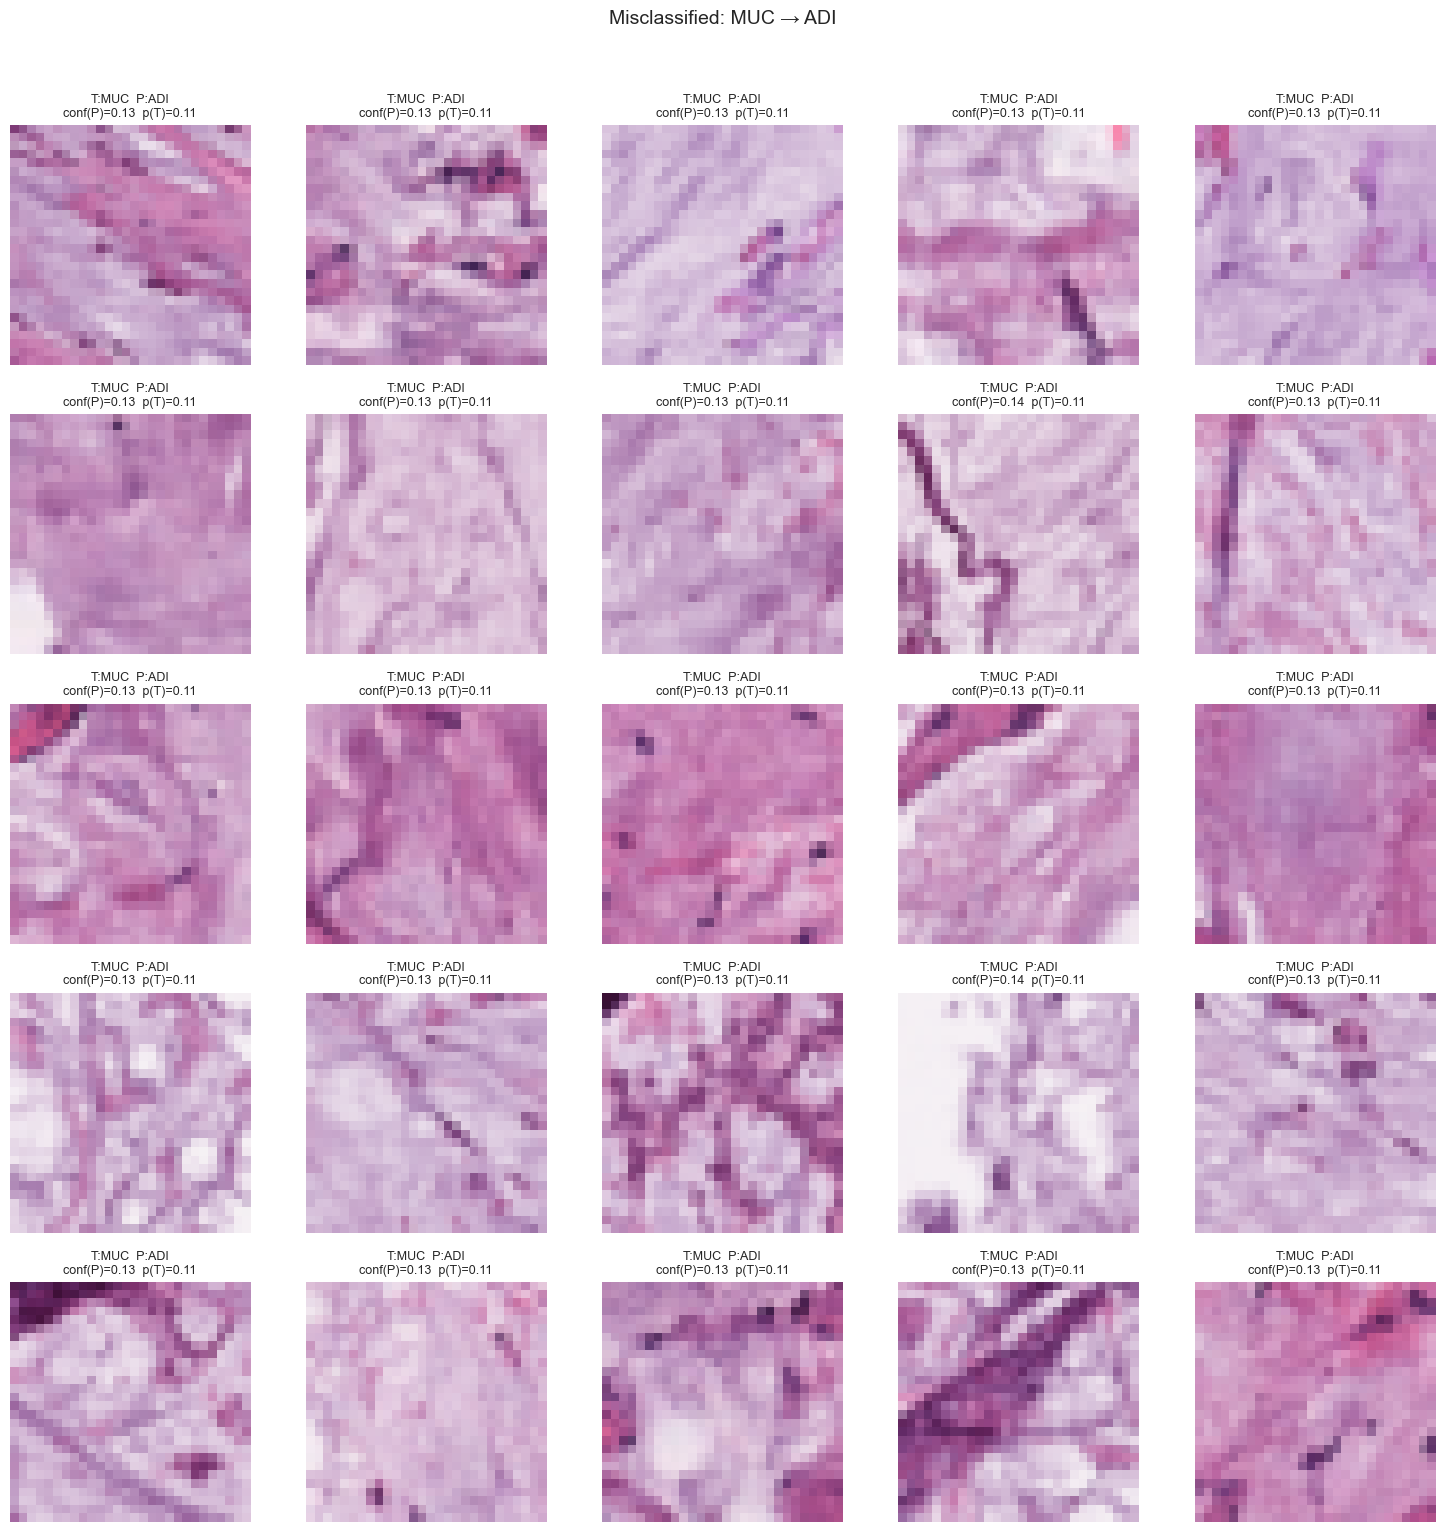

In [43]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# ====== set label id ======
ADI_ID = 4
MUC_ID = 0

short_label_by_id = {
    0: 'ADI', 1: 'BACK', 2: 'DEB', 3: 'LYM', 4: 'MUC',
    5: 'MUS', 6: 'NORM', 7: 'STR', 8: 'TUM'
}

device = next(model.parameters()).device
model.eval()

def show_misclassified(true_id, pred_id, data_loader, max_show=25, cols=5):
    imgs_to_show = []
    infos = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.squeeze().long().to(device)

            logits = model(inputs)                  # (B, 9)
            probs = F.softmax(logits, dim=1)        # (B, 9)
            conf, pred = probs.max(dim=1)           # (B,), (B,)

            # mask: true = true_id AND pred = pred_id
            mask = (targets == true_id) & (pred == pred_id)
            if mask.any():
                sel_inputs = inputs[mask].cpu()
                sel_probs  = probs[mask].cpu()
                sel_conf   = conf[mask].cpu()
                sel_pred   = pred[mask].cpu()
                sel_true   = targets[mask].cpu()

                for i in range(sel_inputs.size(0)):
                    imgs_to_show.append(sel_inputs[i])
                    # simpan info: confidence pred + prob true class
                    infos.append({
                        "true": int(sel_true[i].item()),
                        "pred": int(sel_pred[i].item()),
                        "conf_pred": float(sel_conf[i].item()),
                        "prob_true": float(sel_probs[i, true_id].item()),
                        "prob_pred": float(sel_probs[i, pred_id].item()),
                    })

                    if len(imgs_to_show) >= max_show:
                        break

            if len(imgs_to_show) >= max_show:
                break

    if len(imgs_to_show) == 0:
        print(f"Tidak ada kasus {short_label_by_id[true_id]} → {short_label_by_id[pred_id]} di loader ini.")
        return

    rows = int(np.ceil(len(imgs_to_show) / cols))
    plt.figure(figsize=(cols * 3, rows * 3))

    for idx, (img_t, info) in enumerate(zip(imgs_to_show, infos), start=1):
        plt.subplot(rows, cols, idx)

        # img_t: (C,H,W). Convert ke (H,W,C)
        img = img_t.permute(1, 2, 0).numpy()

        # Kalau kamu normalize saat training, mungkin perlu "denormalize" dulu.
        # Kalau tidak pakai normalize, ini sudah aman.
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        plt.axis("off")

        title = (
            f"T:{short_label_by_id[info['true']]}  P:{short_label_by_id[info['pred']]}\n"
            f"conf(P)={info['conf_pred']:.2f}  p(T)={info['prob_true']:.2f}"
        )
        plt.title(title, fontsize=9)

    plt.suptitle(f"Misclassified: {short_label_by_id[true_id]} → {short_label_by_id[pred_id]}", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

# ====== RUN ======
# pakai train_loader_at_eval dulu (lebih stabil). bisa ganti test_loader.
show_misclassified(ADI_ID, MUC_ID, train_loader_at_eval, max_show=25, cols=5)


In [44]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# ====== set label id ======
ADI_ID = 5
MUC_ID = 7

short_label_by_id = {
    0: 'ADI', 1: 'BACK', 2: 'DEB', 3: 'LYM', 4: 'MUC',
    5: 'MUS', 6: 'NORM', 7: 'STR', 8: 'TUM'
}

device = next(model.parameters()).device
model.eval()

def show_misclassified(true_id, pred_id, data_loader, max_show=25, cols=5):
    imgs_to_show = []
    infos = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.squeeze().long().to(device)

            logits = model(inputs)                  # (B, 9)
            probs = F.softmax(logits, dim=1)        # (B, 9)
            conf, pred = probs.max(dim=1)           # (B,), (B,)

            # mask: true = true_id AND pred = pred_id
            mask = (targets == true_id) & (pred == pred_id)
            if mask.any():
                sel_inputs = inputs[mask].cpu()
                sel_probs  = probs[mask].cpu()
                sel_conf   = conf[mask].cpu()
                sel_pred   = pred[mask].cpu()
                sel_true   = targets[mask].cpu()

                for i in range(sel_inputs.size(0)):
                    imgs_to_show.append(sel_inputs[i])
                    # simpan info: confidence pred + prob true class
                    infos.append({
                        "true": int(sel_true[i].item()),
                        "pred": int(sel_pred[i].item()),
                        "conf_pred": float(sel_conf[i].item()),
                        "prob_true": float(sel_probs[i, true_id].item()),
                        "prob_pred": float(sel_probs[i, pred_id].item()),
                    })

                    if len(imgs_to_show) >= max_show:
                        break

            if len(imgs_to_show) >= max_show:
                break

    if len(imgs_to_show) == 0:
        print(f"Tidak ada kasus {short_label_by_id[true_id]} → {short_label_by_id[pred_id]} di loader ini.")
        return

    rows = int(np.ceil(len(imgs_to_show) / cols))
    plt.figure(figsize=(cols * 3, rows * 3))

    for idx, (img_t, info) in enumerate(zip(imgs_to_show, infos), start=1):
        plt.subplot(rows, cols, idx)

        # img_t: (C,H,W). Convert ke (H,W,C)
        img = img_t.permute(1, 2, 0).numpy()

        # Kalau kamu normalize saat training, mungkin perlu "denormalize" dulu.
        # Kalau tidak pakai normalize, ini sudah aman.
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        plt.axis("off")

        title = (
            f"T:{short_label_by_id[info['true']]}  P:{short_label_by_id[info['pred']]}\n"
            f"conf(P)={info['conf_pred']:.2f}  p(T)={info['prob_true']:.2f}"
        )
        plt.title(title, fontsize=9)

    plt.suptitle(f"Misclassified: {short_label_by_id[true_id]} → {short_label_by_id[pred_id]}", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

# ====== RUN ======
# pakai train_loader_at_eval dulu (lebih stabil). bisa ganti test_loader.
show_misclassified(ADI_ID, MUC_ID, train_loader_at_eval, max_show=25, cols=5)


Tidak ada kasus MUS → STR di loader ini.


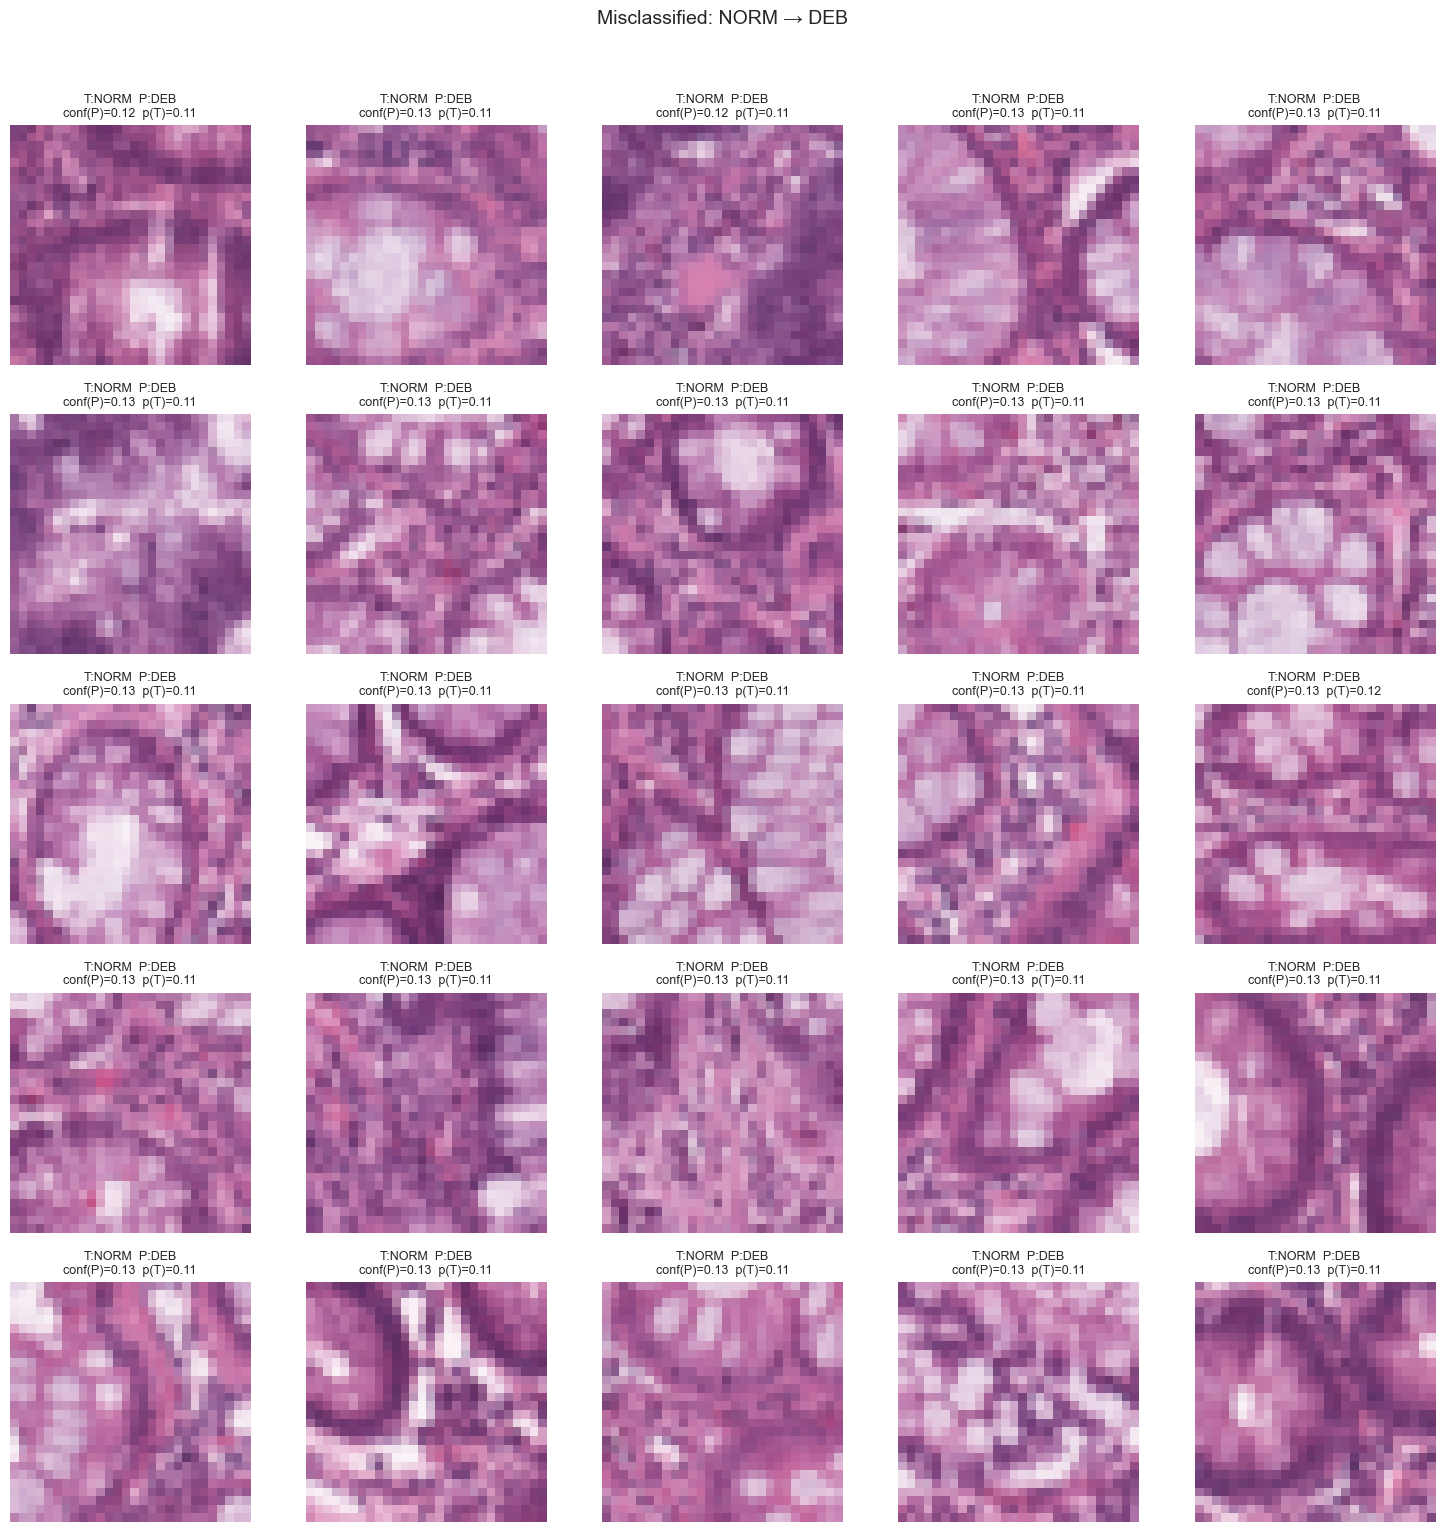

In [45]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# ====== set label id ======
ADI_ID = 6
MUC_ID = 2

short_label_by_id = {
    0: 'ADI', 1: 'BACK', 2: 'DEB', 3: 'LYM', 4: 'MUC',
    5: 'MUS', 6: 'NORM', 7: 'STR', 8: 'TUM'
}

device = next(model.parameters()).device
model.eval()

def show_misclassified(true_id, pred_id, data_loader, max_show=25, cols=5):
    imgs_to_show = []
    infos = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.squeeze().long().to(device)

            logits = model(inputs)                  # (B, 9)
            probs = F.softmax(logits, dim=1)        # (B, 9)
            conf, pred = probs.max(dim=1)           # (B,), (B,)

            # mask: true = true_id AND pred = pred_id
            mask = (targets == true_id) & (pred == pred_id)
            if mask.any():
                sel_inputs = inputs[mask].cpu()
                sel_probs  = probs[mask].cpu()
                sel_conf   = conf[mask].cpu()
                sel_pred   = pred[mask].cpu()
                sel_true   = targets[mask].cpu()

                for i in range(sel_inputs.size(0)):
                    imgs_to_show.append(sel_inputs[i])
                    # simpan info: confidence pred + prob true class
                    infos.append({
                        "true": int(sel_true[i].item()),
                        "pred": int(sel_pred[i].item()),
                        "conf_pred": float(sel_conf[i].item()),
                        "prob_true": float(sel_probs[i, true_id].item()),
                        "prob_pred": float(sel_probs[i, pred_id].item()),
                    })

                    if len(imgs_to_show) >= max_show:
                        break

            if len(imgs_to_show) >= max_show:
                break

    if len(imgs_to_show) == 0:
        print(f"Tidak ada kasus {short_label_by_id[true_id]} → {short_label_by_id[pred_id]} di loader ini.")
        return

    rows = int(np.ceil(len(imgs_to_show) / cols))
    plt.figure(figsize=(cols * 3, rows * 3))

    for idx, (img_t, info) in enumerate(zip(imgs_to_show, infos), start=1):
        plt.subplot(rows, cols, idx)

        # img_t: (C,H,W). Convert ke (H,W,C)
        img = img_t.permute(1, 2, 0).numpy()

        # Kalau kamu normalize saat training, mungkin perlu "denormalize" dulu.
        # Kalau tidak pakai normalize, ini sudah aman.
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        plt.axis("off")

        title = (
            f"T:{short_label_by_id[info['true']]}  P:{short_label_by_id[info['pred']]}\n"
            f"conf(P)={info['conf_pred']:.2f}  p(T)={info['prob_true']:.2f}"
        )
        plt.title(title, fontsize=9)

    plt.suptitle(f"Misclassified: {short_label_by_id[true_id]} → {short_label_by_id[pred_id]}", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

# ====== RUN ======
# pakai train_loader_at_eval dulu (lebih stabil). bisa ganti test_loader.
show_misclassified(ADI_ID, MUC_ID, train_loader_at_eval, max_show=25, cols=5)


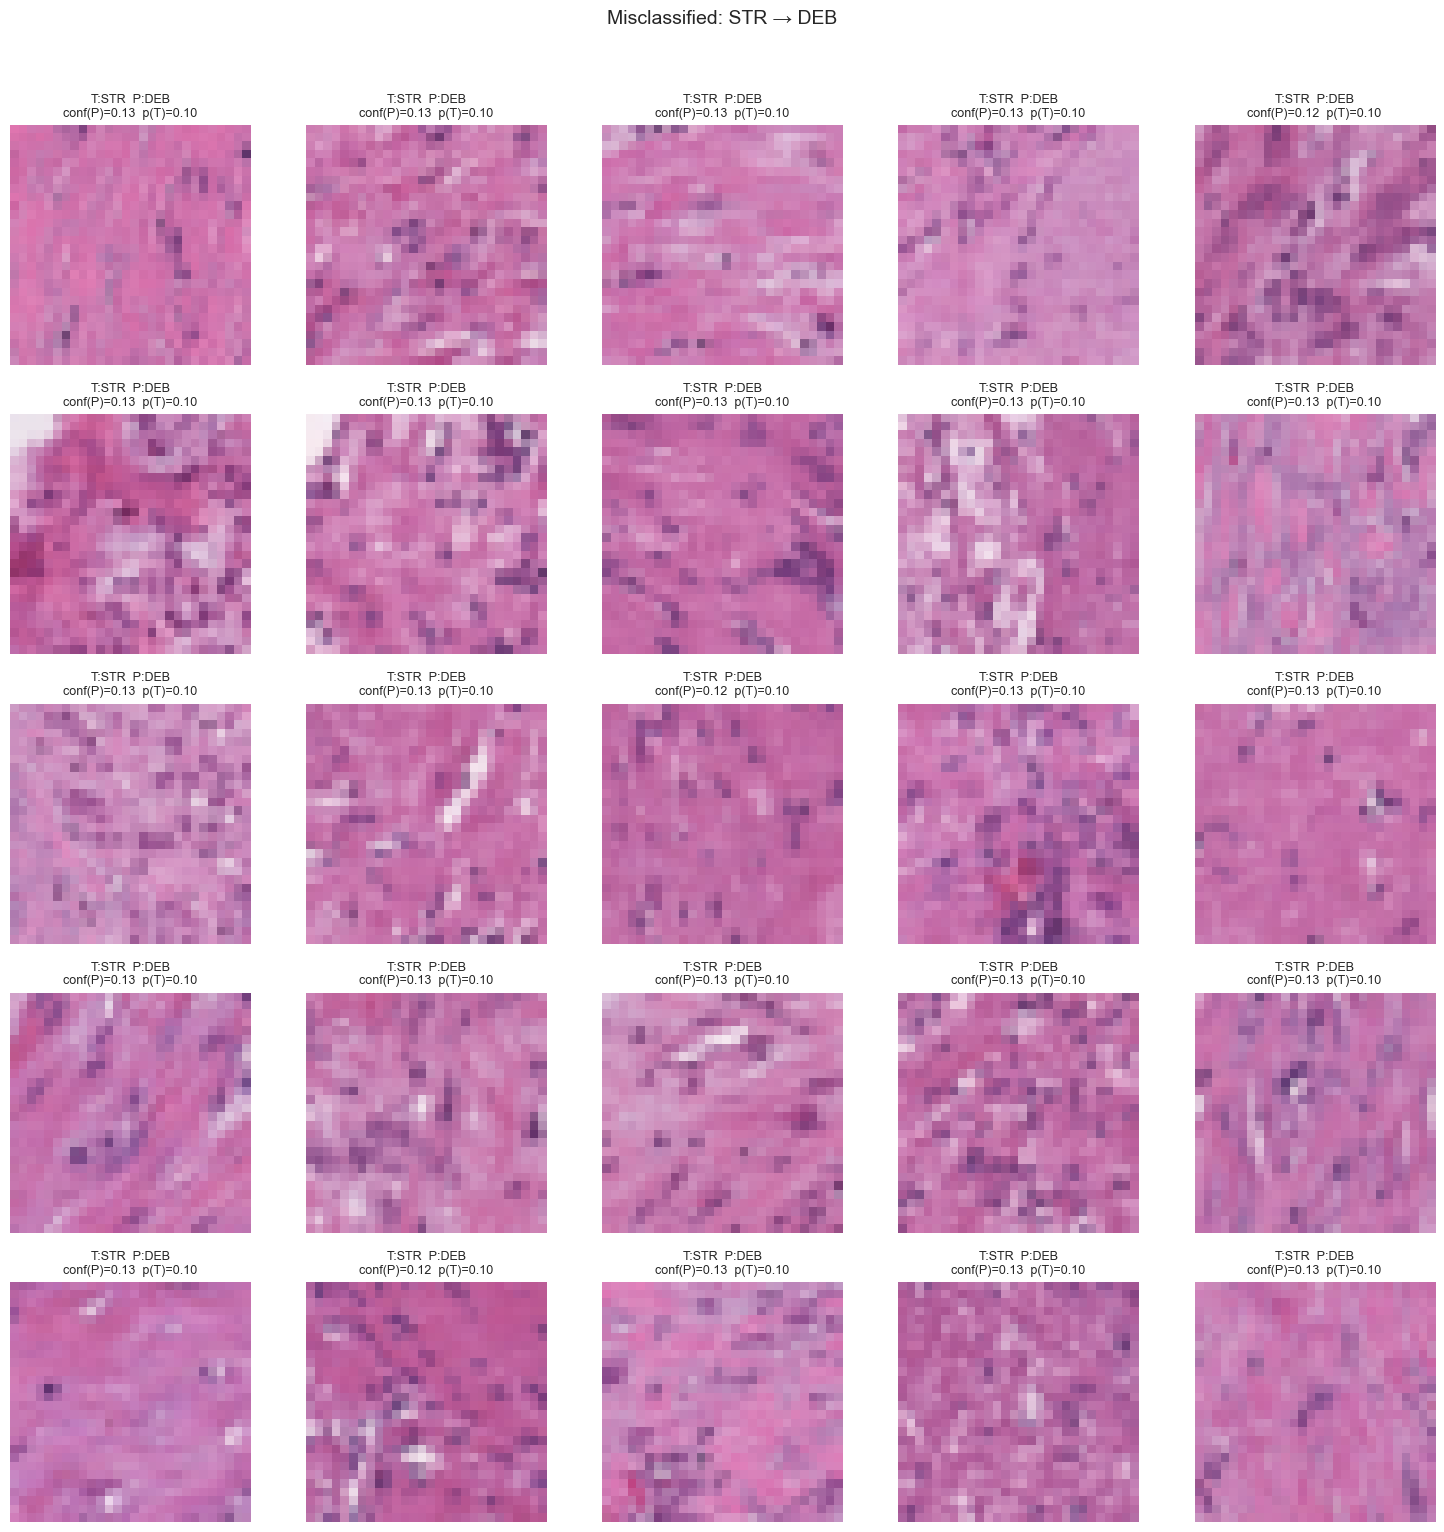

In [46]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# ====== set label id ======
ADI_ID = 7
MUC_ID = 2

short_label_by_id = {
    0: 'ADI', 1: 'BACK', 2: 'DEB', 3: 'LYM', 4: 'MUC',
    5: 'MUS', 6: 'NORM', 7: 'STR', 8: 'TUM'
}

device = next(model.parameters()).device
model.eval()

def show_misclassified(true_id, pred_id, data_loader, max_show=25, cols=5):
    imgs_to_show = []
    infos = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.squeeze().long().to(device)

            logits = model(inputs)                  # (B, 9)
            probs = F.softmax(logits, dim=1)        # (B, 9)
            conf, pred = probs.max(dim=1)           # (B,), (B,)

            # mask: true = true_id AND pred = pred_id
            mask = (targets == true_id) & (pred == pred_id)
            if mask.any():
                sel_inputs = inputs[mask].cpu()
                sel_probs  = probs[mask].cpu()
                sel_conf   = conf[mask].cpu()
                sel_pred   = pred[mask].cpu()
                sel_true   = targets[mask].cpu()

                for i in range(sel_inputs.size(0)):
                    imgs_to_show.append(sel_inputs[i])
                    # simpan info: confidence pred + prob true class
                    infos.append({
                        "true": int(sel_true[i].item()),
                        "pred": int(sel_pred[i].item()),
                        "conf_pred": float(sel_conf[i].item()),
                        "prob_true": float(sel_probs[i, true_id].item()),
                        "prob_pred": float(sel_probs[i, pred_id].item()),
                    })

                    if len(imgs_to_show) >= max_show:
                        break

            if len(imgs_to_show) >= max_show:
                break

    if len(imgs_to_show) == 0:
        print(f"Tidak ada kasus {short_label_by_id[true_id]} → {short_label_by_id[pred_id]} di loader ini.")
        return

    rows = int(np.ceil(len(imgs_to_show) / cols))
    plt.figure(figsize=(cols * 3, rows * 3))

    for idx, (img_t, info) in enumerate(zip(imgs_to_show, infos), start=1):
        plt.subplot(rows, cols, idx)

        # img_t: (C,H,W). Convert ke (H,W,C)
        img = img_t.permute(1, 2, 0).numpy()

        # Kalau kamu normalize saat training, mungkin perlu "denormalize" dulu.
        # Kalau tidak pakai normalize, ini sudah aman.
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        plt.axis("off")

        title = (
            f"T:{short_label_by_id[info['true']]}  P:{short_label_by_id[info['pred']]}\n"
            f"conf(P)={info['conf_pred']:.2f}  p(T)={info['prob_true']:.2f}"
        )
        plt.title(title, fontsize=9)

    plt.suptitle(f"Misclassified: {short_label_by_id[true_id]} → {short_label_by_id[pred_id]}", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

# ====== RUN ======
# pakai train_loader_at_eval dulu (lebih stabil). bisa ganti test_loader.
show_misclassified(ADI_ID, MUC_ID, train_loader_at_eval, max_show=25, cols=5)


violin + rgb

C:\Users\Dhanang Listyo W\AppData\Local\Temp\ipykernel_17784\3279330914.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='label', y='Red_mean', data=df, palette='magma')
C:\Users\Dhanang Listyo W\AppData\Local\Temp\ipykernel_17784\3279330914.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='label', y='Green_mean', data=df, palette='magma')
C:\Users\Dhanang Listyo W\AppData\Local\Temp\ipykernel_17784\3279330914.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='label', y='Blue_mean', data=df, palette='magma')


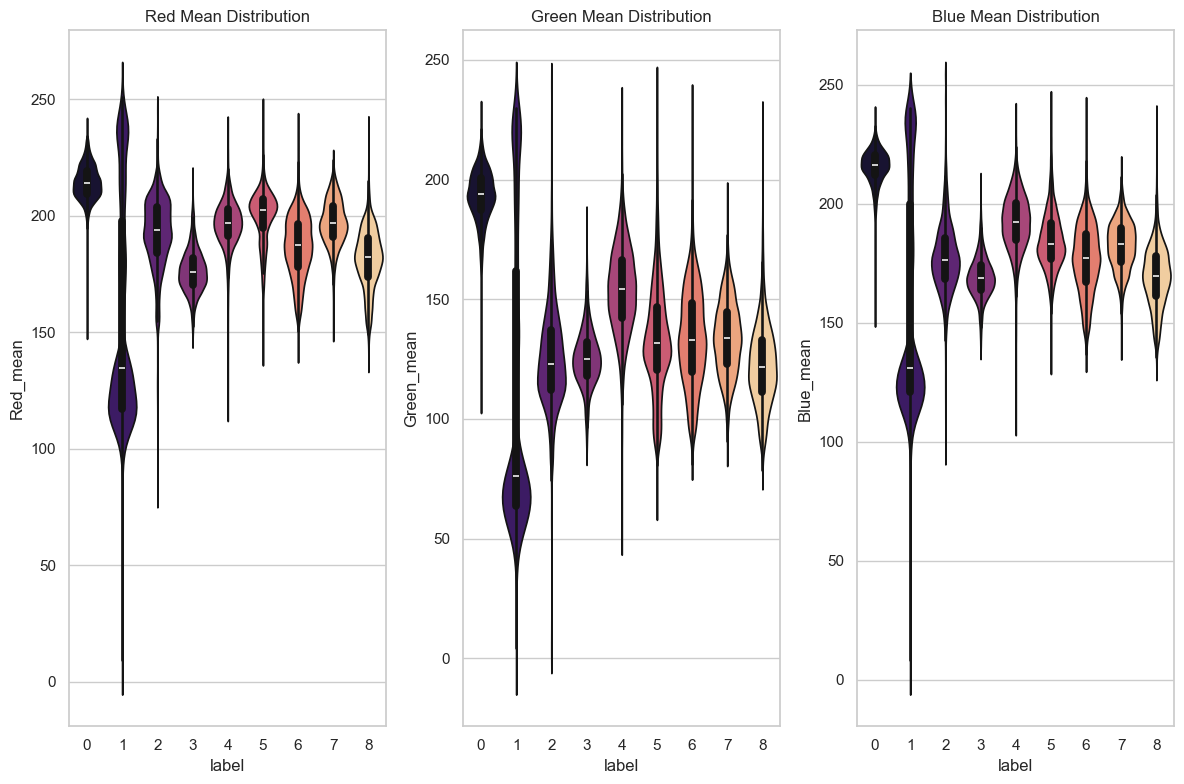

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Hitung rata-rata R, G, B untuk setiap gambar
# Asumsi train_dataset.imgs memiliki shape (N, 28, 28, 3)
images = train_dataset.imgs
labels = train_dataset.labels.flatten()

# Hitung rata-rata pixel pada sumbu (axis) 1 dan 2 (H dan W)
# Hasilnya adalah array dengan shape (N, 3) -> [Mean_R, Mean_G, Mean_B]
rgb_means = images.mean(axis=(1, 2))

# 2. Masukkan ke dalam Pandas DataFrame
df = pd.DataFrame(rgb_means, columns=['Red_mean', 'Green_mean', 'Blue_mean'])
df['label'] = labels

# 3. Membuat violin plot untuk R, G, B
sns.set_theme(style="whitegrid")

# Buat plot dengan satu sumbu untuk RGB dan label
plt.figure(figsize=(12, 8))

# Violin plot untuk Red
plt.subplot(131)
sns.violinplot(x='label', y='Red_mean', data=df, palette='magma')
plt.title("Red Mean Distribution")

# Violin plot untuk Green
plt.subplot(132)
sns.violinplot(x='label', y='Green_mean', data=df, palette='magma')
plt.title("Green Mean Distribution")

# Violin plot untuk Blue
plt.subplot(133)
sns.violinplot(x='label', y='Blue_mean', data=df, palette='magma')
plt.title("Blue Mean Distribution")

# Tampilkan grafik
plt.tight_layout()
plt.show()


C:\Users\Dhanang Listyo W\AppData\Local\Temp\ipykernel_17784\1522000814.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='label', y='Red_mean', data=df, palette='magma')
C:\Users\Dhanang Listyo W\AppData\Local\Temp\ipykernel_17784\1522000814.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='label', y='Green_mean', data=df, palette='magma')
C:\Users\Dhanang Listyo W\AppData\Local\Temp\ipykernel_17784\1522000814.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='label', y='Blue_mean', data=df, palette='magma')


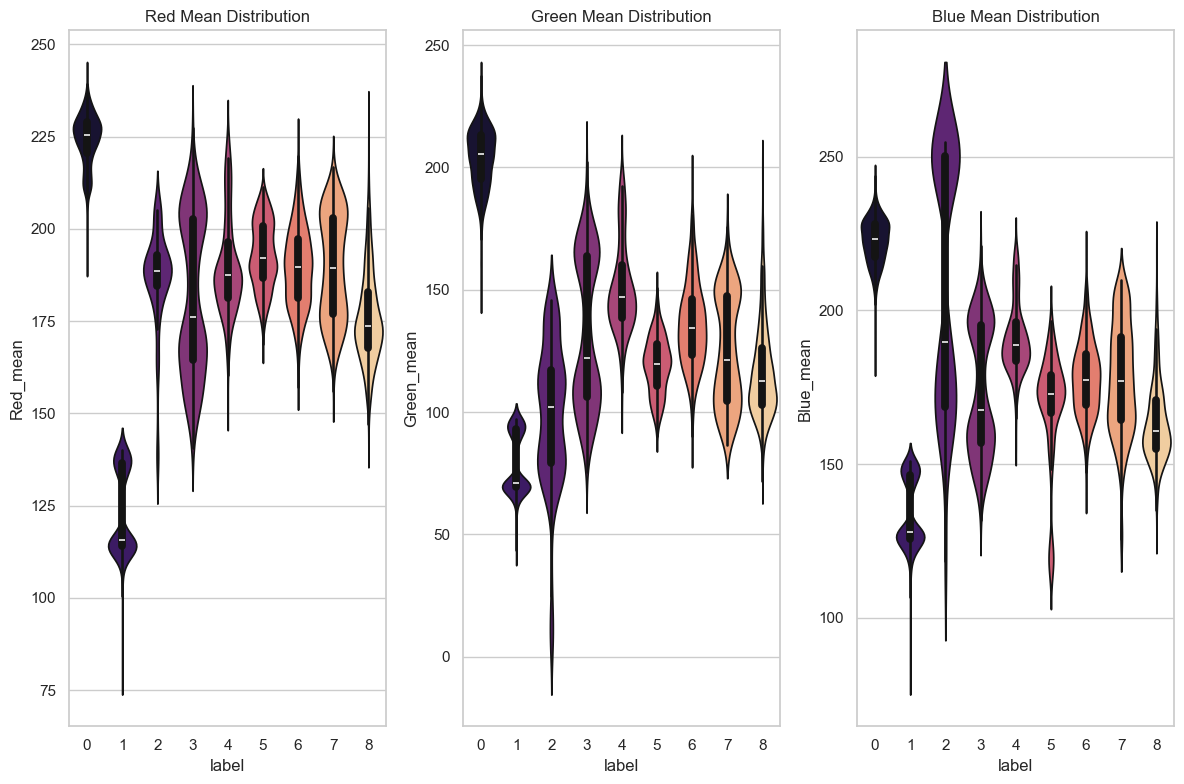

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Hitung rata-rata R, G, B untuk setiap gambar
# Asumsi train_dataset.imgs memiliki shape (N, 28, 28, 3)
images = test_dataset.imgs
labels = test_dataset.labels.flatten()

# Hitung rata-rata pixel pada sumbu (axis) 1 dan 2 (H dan W)
# Hasilnya adalah array dengan shape (N, 3) -> [Mean_R, Mean_G, Mean_B]
rgb_means = images.mean(axis=(1, 2))

# 2. Masukkan ke dalam Pandas DataFrame
df = pd.DataFrame(rgb_means, columns=['Red_mean', 'Green_mean', 'Blue_mean'])
df['label'] = labels

# 3. Membuat violin plot untuk R, G, B
sns.set_theme(style="whitegrid")

# Buat plot dengan satu sumbu untuk RGB dan label
plt.figure(figsize=(12, 8))

# Violin plot untuk Red
plt.subplot(131)
sns.violinplot(x='label', y='Red_mean', data=df, palette='magma')
plt.title("Red Mean Distribution")

# Violin plot untuk Green
plt.subplot(132)
sns.violinplot(x='label', y='Green_mean', data=df, palette='magma')
plt.title("Green Mean Distribution")

# Violin plot untuk Blue
plt.subplot(133)
sns.violinplot(x='label', y='Blue_mean', data=df, palette='magma')
plt.title("Blue Mean Distribution")

# Tampilkan grafik
plt.tight_layout()
plt.show()

C:\Users\Dhanang Listyo W\AppData\Local\Temp\ipykernel_17784\2645063530.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='label', y='Red_mean', data=df, palette='magma')


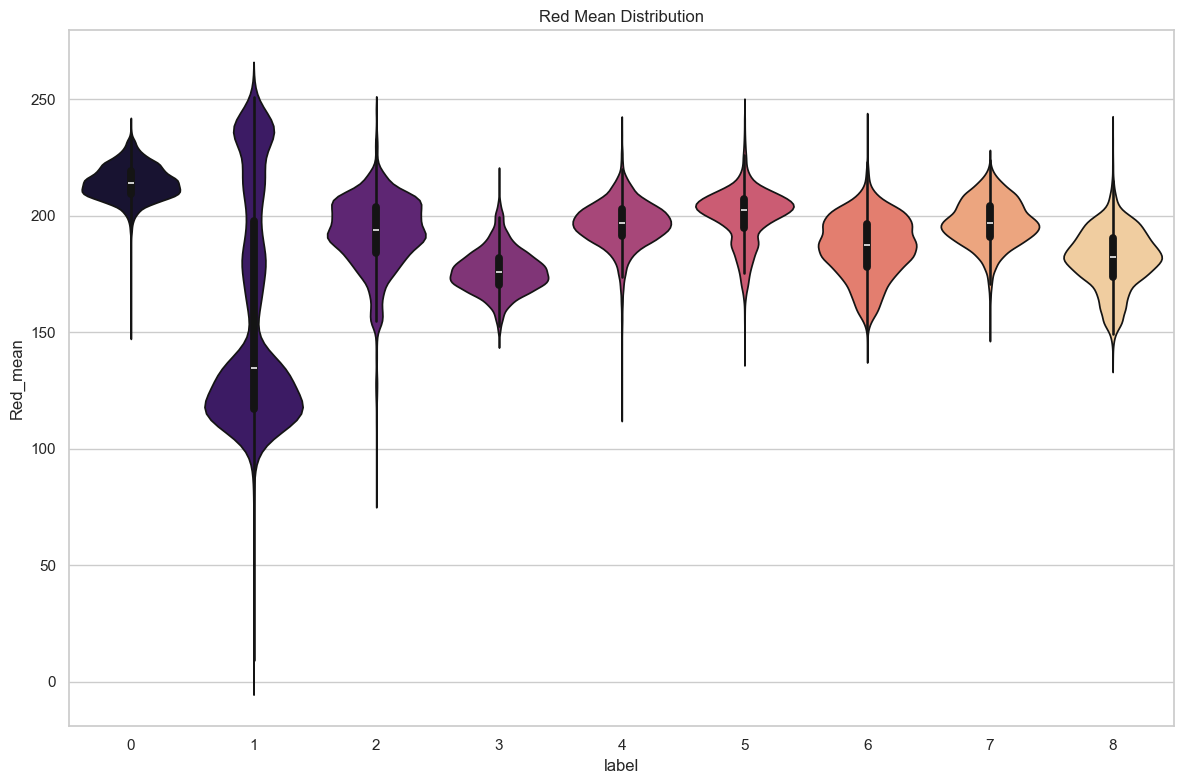

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Hitung rata-rata R, G, B untuk setiap gambar
# Asumsi train_dataset.imgs memiliki shape (N, 28, 28, 3)
images = train_dataset.imgs
labels = train_dataset.labels.flatten()

# Hitung rata-rata pixel pada sumbu (axis) 1 dan 2 (H dan W)
# Hasilnya adalah array dengan shape (N, 3) -> [Mean_R, Mean_G, Mean_B]
rgb_means = images.mean(axis=(1, 2))

# 2. Masukkan ke dalam Pandas DataFrame
df = pd.DataFrame(rgb_means, columns=['Red_mean', 'Green_mean', 'Blue_mean'])
df['label'] = labels

# 3. Membuat violin plot untuk RGB secara terpisah
sns.set_theme(style="whitegrid")

# Buat violin plot untuk Red, Green, Blue masing-masing
plt.figure(figsize=(12, 8))

# Violin plot untuk Red
sns.violinplot(x='label', y='Red_mean', data=df, palette='magma')
plt.title("Red Mean Distribution")

# Tampilkan grafik
plt.tight_layout()
plt.show()


C:\Users\Dhanang Listyo W\AppData\Local\Temp\ipykernel_17784\1302420394.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='label', y='Red_mean', data=df, palette='magma')


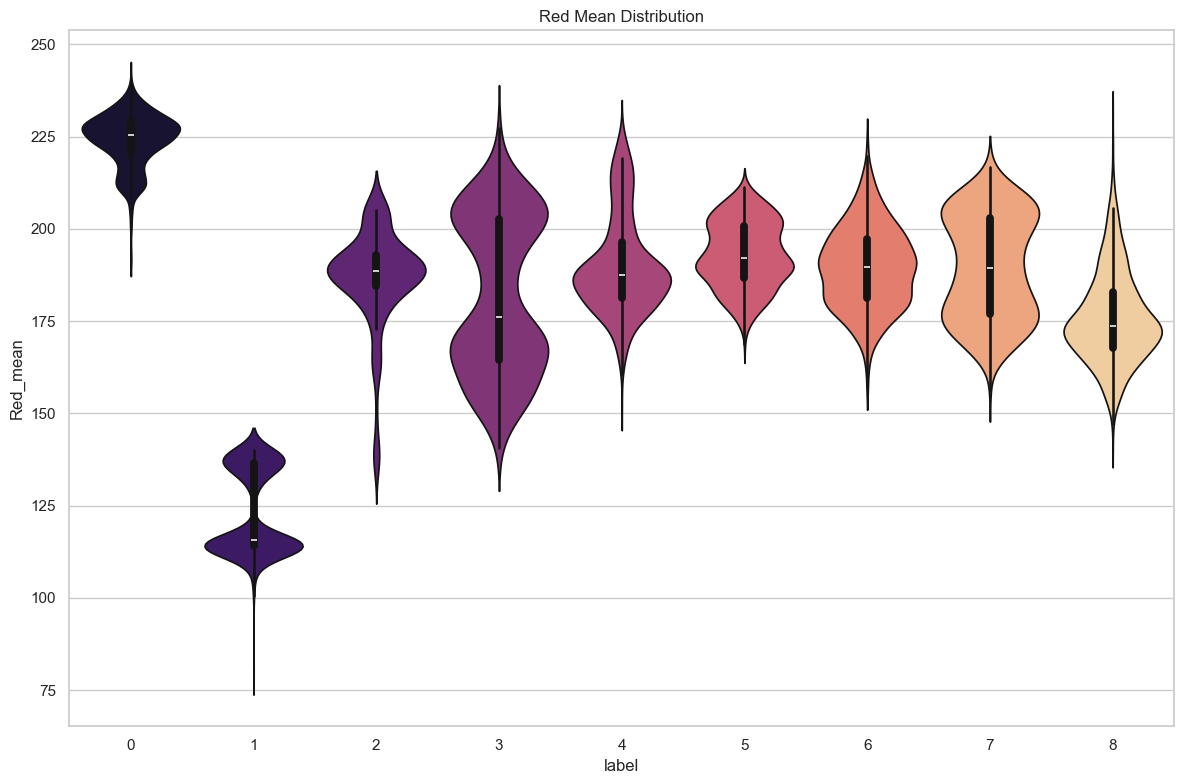

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Hitung rata-rata R, G, B untuk setiap gambar
# Asumsi train_dataset.imgs memiliki shape (N, 28, 28, 3)
images = test_dataset.imgs
labels = test_dataset.labels.flatten()

# Hitung rata-rata pixel pada sumbu (axis) 1 dan 2 (H dan W)
# Hasilnya adalah array dengan shape (N, 3) -> [Mean_R, Mean_G, Mean_B]
rgb_means = images.mean(axis=(1, 2))

# 2. Masukkan ke dalam Pandas DataFrame
df = pd.DataFrame(rgb_means, columns=['Red_mean', 'Green_mean', 'Blue_mean'])
df['label'] = labels

# 3. Membuat violin plot untuk RGB secara terpisah
sns.set_theme(style="whitegrid")

# Buat violin plot untuk Red, Green, Blue masing-masing
plt.figure(figsize=(12, 8))

# Violin plot untuk Red
sns.violinplot(x='label', y='Red_mean', data=df, palette='magma')
plt.title("Red Mean Distribution")

# Tampilkan grafik
plt.tight_layout()
plt.show()

In [52]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        """
        model: torch.nn.Module (sudah load weight & eval)
        target_layer: layer conv terakhir (misal model.layer4[-1].conv2 di ResNet18)
        """
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        # hook activations
        self.fwd_hook = self.target_layer.register_forward_hook(self._forward_hook)
        # hook gradients
        self.bwd_hook = self.target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        self.activations = out.detach()

    def _backward_hook(self, module, grad_in, grad_out):
        # grad_out[0] shape sama seperti activations
        self.gradients = grad_out[0].detach()

    def generate(self, input_tensor, class_idx=None):
        """
        input_tensor: shape (1, C, H, W) sudah di device
        class_idx: target class index (int). Kalau None, pakai predicted class.
        return: cam (H, W) dalam numpy [0..1], predicted_class, probabilities (optional)
        """
        self.model.zero_grad()

        logits = self.model(input_tensor)           # (1, num_classes)
        probs = F.softmax(logits, dim=1)            # (1, num_classes)
        pred_class = torch.argmax(probs, dim=1).item()

        if class_idx is None:
            class_idx = pred_class

        score = logits[:, class_idx]                # scalar (1,)
        score.backward(retain_graph=True)

        # activations: (1, K, h, w)
        # gradients:    (1, K, h, w)
        grads = self.gradients
        acts  = self.activations

        # weights = global average pooling grad over spatial dim
        weights = grads.mean(dim=(2, 3), keepdim=True)          # (1, K, 1, 1)

        # weighted sum
        cam = (weights * acts).sum(dim=1, keepdim=True)         # (1, 1, h, w)
        cam = F.relu(cam)

        # upsample ke ukuran input
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)

        # normalize ke [0..1]
        cam = cam[0, 0]
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam.cpu().numpy(), pred_class, probs.detach().cpu().numpy()

    def close(self):
        self.fwd_hook.remove()
        self.bwd_hook.remove()


In [53]:
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def unnormalize(img_tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    # img_tensor: (3,H,W) torch
    return img_tensor * std + mean

def show_gradcam(input_tensor_1, cam_2d, title="Grad-CAM", alpha=0.45):
    """
    input_tensor_1: (1,3,H,W) torch, sudah normalized (yang kamu feed ke model)
    cam_2d: (H,W) numpy [0..1]
    """
    img = input_tensor_1[0].detach().cpu()
    img = unnormalize(img).clamp(0,1)   # (3,H,W)
    img_np = img.permute(1,2,0).numpy() # (H,W,3)

    plt.figure(figsize=(6,6))
    plt.imshow(img_np)
    plt.imshow(cam_2d, cmap='jet', alpha=alpha)  # heatmap overlay
    plt.title(title)
    plt.axis('off')
    plt.show()


In [55]:
inputs = inputs.to(device)
targets = targets.squeeze().long().to(device)


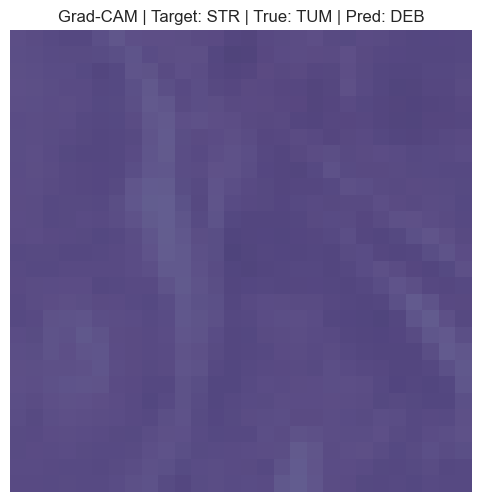

In [57]:
inputs, targets = next(iter(test_loader))

inputs = inputs.to(device)
targets = targets.squeeze().long().to(device)

idx = 0                  # index sample dalam batch
x = inputs[idx:idx+1]    # shape: [1, 3, 28, 28]
y_true = targets[idx].item()

target_idx = 7  # STR

cam, pred_class, probs = gradcam.generate(
    x,
    class_idx=target_idx
)

title = (
    f"Grad-CAM | Target: {class_labels[target_idx]} | "
    f"True: {class_labels[y_true]} | "
    f"Pred: {class_labels[pred_class]}"
)

show_gradcam(x, cam, title=title)


In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Kalau dataset kamu pakai normalisasi ImageNet (umum untuk ResNet):
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def unnormalize(img_tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    return img_tensor * std + mean

def plot_gradcam_triplet(x_1, cam_2d, title="", alpha=0.45):
    """
    x_1: (1,3,H,W) torch tensor (normalized)
    cam_2d: (H,W) numpy [0..1]
    """
    img = x_1[0].detach().cpu()            # (3,H,W)
    img = unnormalize(img).clamp(0,1)      # (3,H,W)
    img_np = img.permute(1,2,0).numpy()    # (H,W,3)

    fig, axes = plt.subplots(1, 3, figsize=(14, 5))

    # 1) Original
    axes[0].imshow(img_np)
    axes[0].set_title("Original HE")
    axes[0].axis("off")

    # 2) Heatmap only
    axes[1].imshow(cam_2d, cmap="jet")
    axes[1].set_title("Grad-CAM Heatmap")
    axes[1].axis("off")

    # 3) Overlay
    axes[2].imshow(img_np)
    axes[2].imshow(cam_2d, cmap="jet", alpha=alpha)
    axes[2].set_title("Overlay (HE + Grad-CAM)")
    axes[2].axis("off")

    if title:
        fig.suptitle(title, fontsize=12)

    plt.tight_layout()
    plt.show()


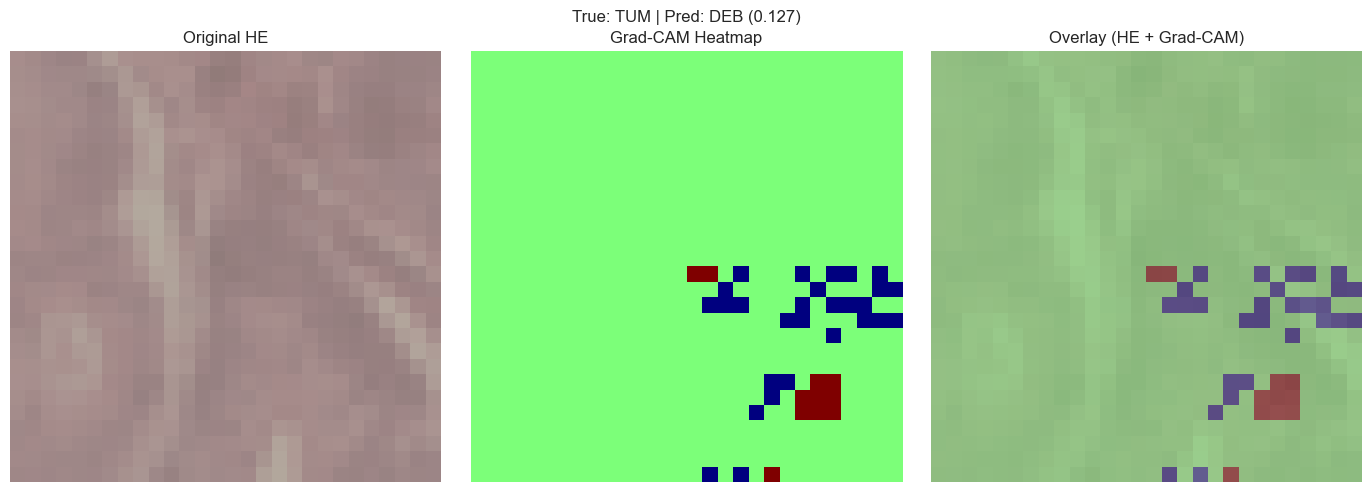

In [59]:
cam, pred_class, probs = gradcam.generate(x, class_idx=None)

title = f"True: {class_labels[y_true]} | Pred: {class_labels[pred_class]} ({probs[0,pred_class]:.3f})"
plot_gradcam_triplet(x, cam, title=title, alpha=0.45)


In [60]:
def plot_all_classes_for_one_image(x, y_true, class_labels, gradcam):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    for idx in range(len(class_labels)):
        cam, _, probs = gradcam.generate(x, class_idx=idx)

        ax = axes[idx // 3, idx % 3]
        ax.imshow(cam, cmap="jet")
        ax.set_title(f"{class_labels[idx]}\nProb: {probs[0, idx]:.3f}")
        ax.axis("off")

    plt.suptitle(f"True Label: {class_labels[y_true]}")
    plt.tight_layout()
    plt.show()


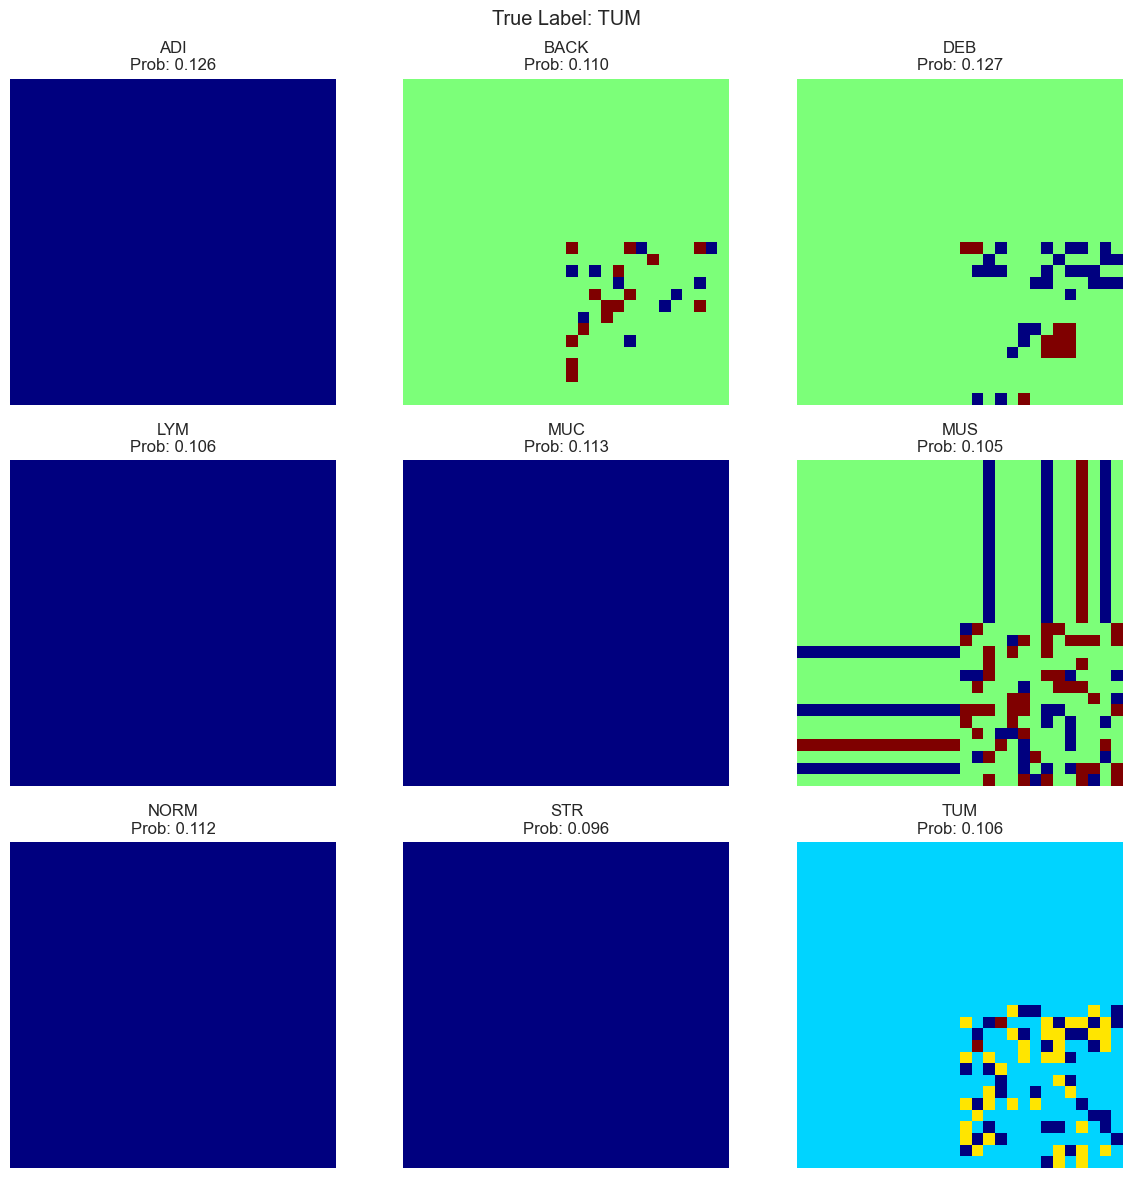

In [61]:
plot_all_classes_for_one_image(x, y_true, class_labels, gradcam)


In [62]:
def plot_one_sample_per_class(test_loader, model, gradcam, class_labels, device):
    model.eval()
    shown_classes = set()

    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.squeeze().long().to(device)

        for i in range(inputs.size(0)):
            label = targets[i].item()

            if label not in shown_classes:
                x = inputs[i:i+1]
                cam, pred_class, probs = gradcam.generate(x)

                title = f"True: {class_labels[label]} | Pred: {class_labels[pred_class]} ({probs[0,pred_class]:.3f})"
                plot_gradcam_triplet(x, cam, title=title)

                shown_classes.add(label)

            if len(shown_classes) == len(class_labels):
                return


In [63]:
def plot_gradcam_all_classes(test_loader, model, gradcam, class_labels, device):
    model.eval()
    
    num_classes = len(class_labels)
    fig, axes = plt.subplots(num_classes, 3, figsize=(9, 3 * num_classes))
    
    shown_classes = set()

    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.squeeze().long().to(device)

        for i in range(inputs.size(0)):
            label = targets[i].item()

            if label not in shown_classes:
                x = inputs[i:i+1]

                cam, pred_class, probs = gradcam.generate(x)

                # ===== Prepare Image =====
                img = x[0].detach().cpu()
                img = unnormalize(img).clamp(0,1)
                img_np = img.permute(1,2,0).numpy()

                row = label  # supaya urut sesuai index class

                # Original
                axes[row, 0].imshow(img_np)
                axes[row, 0].set_title(f"{class_labels[label]} - Original")
                axes[row, 0].axis("off")

                # Heatmap
                axes[row, 1].imshow(cam, cmap="jet")
                axes[row, 1].set_title("Grad-CAM")
                axes[row, 1].axis("off")

                # Overlay
                axes[row, 2].imshow(img_np)
                axes[row, 2].imshow(cam, cmap="jet", alpha=0.45)
                axes[row, 2].set_title(
                    f"Overlay\nPred: {class_labels[pred_class]} ({probs[0,pred_class]:.3f})"
                )
                axes[row, 2].axis("off")

                shown_classes.add(label)

            if len(shown_classes) == num_classes:
                plt.tight_layout()
                plt.show()
                return


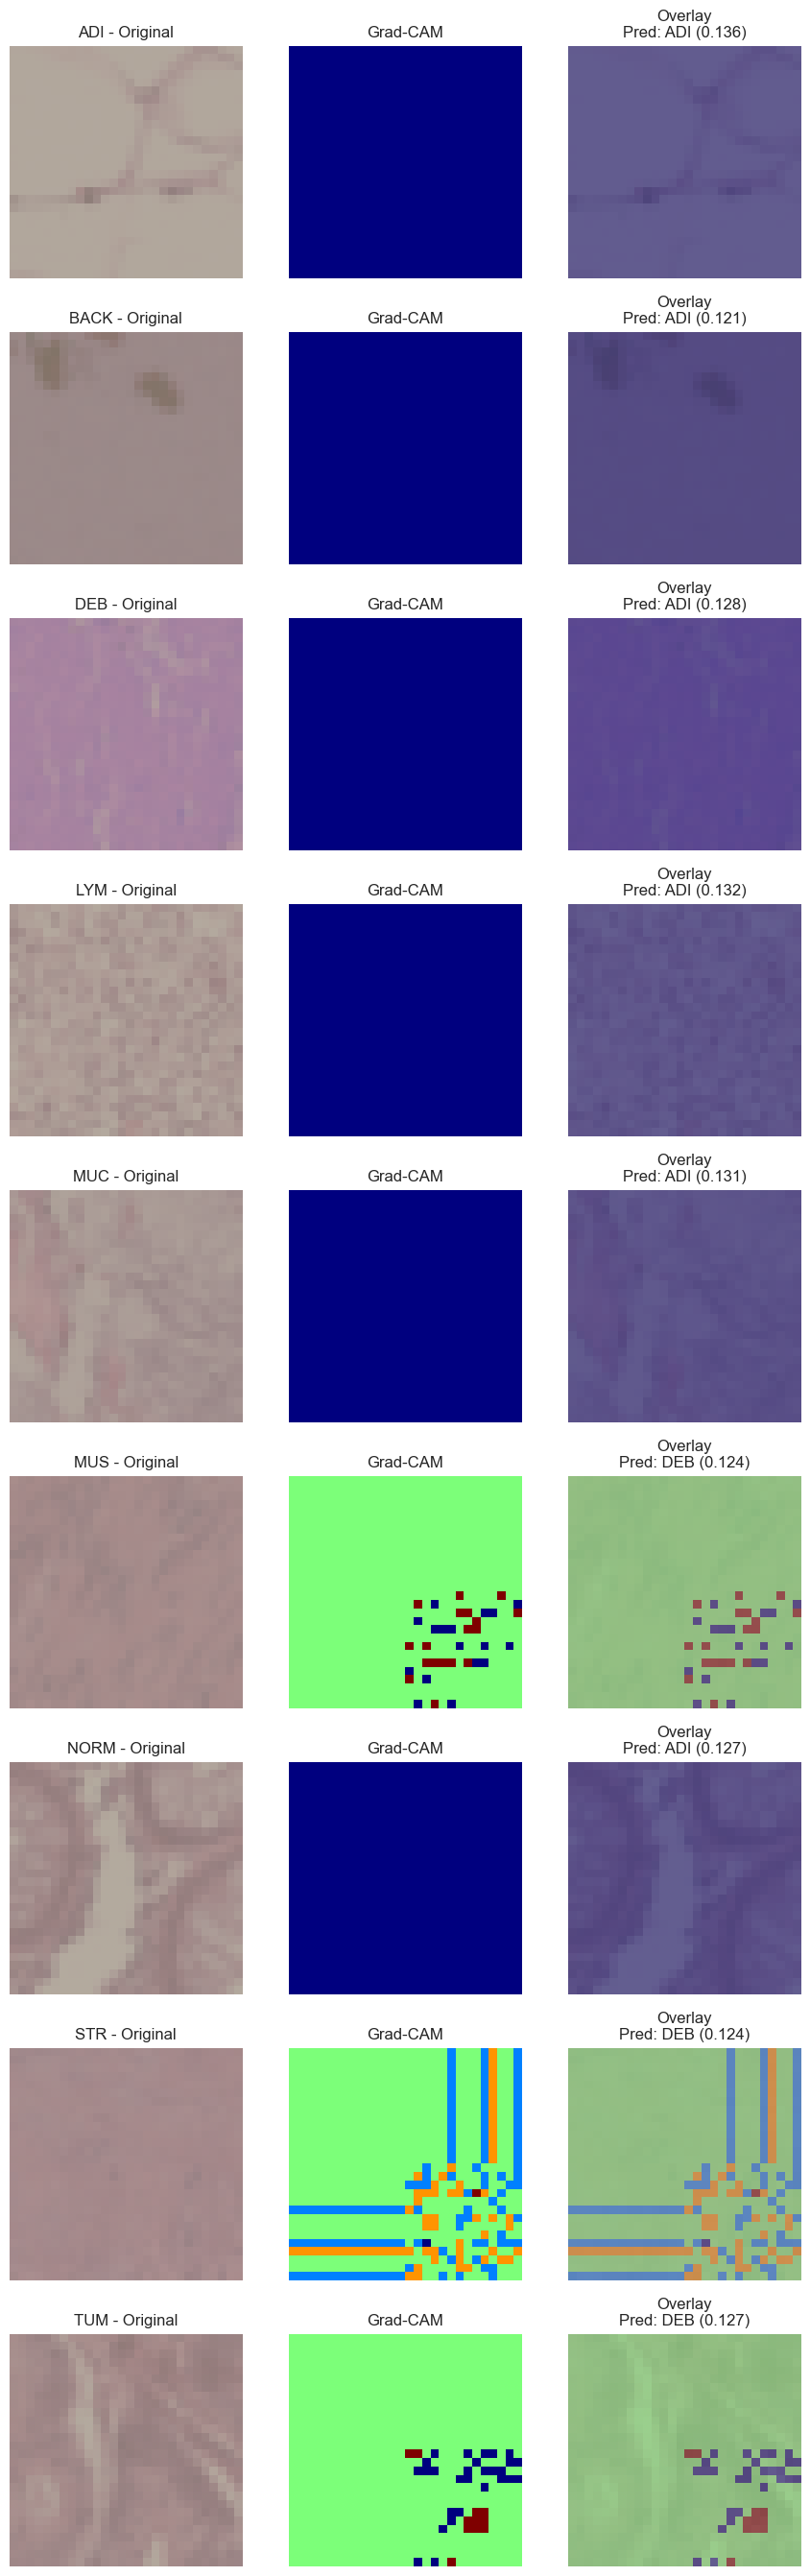

In [65]:
plot_gradcam_all_classes(
    test_loader,
    model,
    gradcam,
    class_labels,
    device
)
